In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Define the path to your zip file
zip_path = '/content/drive/My Drive/Datasets/datasets.zip'

# Define the extraction path
extract_to = '/content/datasets'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

os.makedirs('model', exist_ok=True)
os.makedirs('cache', exist_ok=True)

# Unzip the file
!unzip -q "$zip_path" -d "$extract_to"


Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 28 21:08:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary



from tqdm.auto import tqdm

import numpy as np
import pandas as pd

from PIL import ImageDraw, Image

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from collections import Counter
import seaborn as sns

from datetime import datetime
import os
import random
import time

vcpi_util.py imported directly due to google colab not working

In [4]:

def show_history_plus(history, fields):

    # summarize history for accuracy
    for hist in fields:

        plt.plot(history[hist])

        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
    plt.legend(list(history.keys()), loc='lower right')
    plt.show()



def show_history(history):

    for key in history.keys():

        # summarize history for accuracy
        plt.plot(history[key])
        plt.title(key)
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.show()


def show_histories(histories, model_names, field='accuracy'):

    # summarize history for accuracy
    for hist in histories:
        plt.plot(hist[field])

    plt.ylabel(field)
    plt.xlabel('epoch')
    plt.legend(model_names, loc='lower right')
    plt.show()


def show_accuracies(train_acc, eval_acc, model_names):
    fig, ax = plt.subplots()
    X = np.arange(len(model_names))

    minT = min(train_acc)
    minE = min(eval_acc)
    min_val = min([minT, minE])

    plt.bar(X, eval_acc, width = 0.4, color = 'b', label='eval')
    plt.bar(X + 0.4, train_acc, color = 'r', width = 0.4, label = "train")
    plt.xticks(X + 0.4 / 2, model_names)
    plt.ylim(top = 100, bottom = min_val - 2)
    plt.legend(loc='lower right')
    plt.show()


def show_histogram(data, classes):

    target_np = [x.numpy().item() for x in data]
    res = Counter(target_np)
    print(res)

    values = [res[x] for x in range(len(classes))]
    indexes = np.arange(len(classes))


    plt.bar(indexes, values, 1)
    plt.xticks(indexes , classes, rotation=45, ha='right')
    plt.show()


def show_confusion_matrix(ground_truth, preds, num_classes):
    cf_matrix = confusion_matrix(ground_truth, preds)

    # Normalize the confusion matrix
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], range(num_classes), range(num_classes))

    # Create a custom color map: black for zero, gradient for other values
    colors = ['lightcoral', 'blue']
    n_bins = 100  # Number of bins for the gradient
    cmap = ListedColormap(['lightcoral'] + plt.cm.Blues(np.linspace(0, 1, n_bins)).tolist())

    # Create the plot
    plt.figure(figsize=(14, 8))  # Increase the figure size for better readability
    sns.set(font_scale=1.2)  # Increase the font scale for labels
    heatmap = sns.heatmap(df_cm, annot=False, fmt='.3f', cmap=cmap, cbar=True)  # Use custom color map, disable annotations

    # Add labels, title, and adjust layout
    heatmap.set_xlabel('Predicted Labels', fontsize=14)
    heatmap.set_ylabel('True Labels', fontsize=14)
    heatmap.set_title('Normalized Confusion Matrix', fontsize=16)

    plt.show()




def show_loaded_images(rows, cols, data,classes):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):
        img, label = data[a]
        subplot_title=(classes[label])
        axes.ravel()[a].set_title(subplot_title)
        axes.ravel()[a].imshow(np.transpose(img.numpy(), (1,2,0)), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()


def show_transformed_images(rows, cols, data, classes):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):
        img, target = data[a]
        subplot_title=(classes[target])
        axes.ravel()[a].set_title(subplot_title)
        axes.ravel()[a].imshow(np.transpose(img.numpy(),(1,2,0)), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()

def show_predicted_images(rows, cols, data, classes):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):
        img = data[a]
        axes.ravel()[a].imshow(np.transpose(img.numpy(),(1,2,0)), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()

def show_images(rows, cols, images, targets, classes):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):
        img, target = images[a], targets[a]
        subplot_title=(classes[target])
        axes.ravel()[a].set_title(subplot_title)
        axes.ravel()[a].imshow(np.transpose(img.numpy(),(1,2,0)), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img, classes):

    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img_np = np.transpose(img.numpy(), (1,2,0))
    plt.imshow(img_np, cmap=plt.cm.gray)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                  100*np.max(predictions_array),
                                  classes[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label, num_classes):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(num_classes))
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')



In [5]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

def plot_predictions(images, predictions, ground_truth, classes, num_rows= 5, num_cols=3 ):

    num_images = min(num_rows*num_cols, len(predictions))
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))

    for i in range(num_images):

        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], ground_truth, images, classes)

        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth, len(classes))

    plt.tight_layout()
    plt.show()


def plot_mismatched(images, predictions, ground_truth, classes, num_rows=5, num_cols=3):

    num_images = min(num_rows * num_cols, len(predictions))
    fig = plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))  # Set figure size

    plotted_images = 0
    i = 0
    plotted_any = False  # Flag to track if any mismatched predictions were plotted

    while plotted_images < num_images and i < len(predictions):

        # If this current prediction is wrong then plot it
        prediction_array = predictions[i]
        true_label = ground_truth[i]  # Just the label, not .item()

        predicted_label = np.argmax(prediction_array)

        if predicted_label != true_label:

            plt.subplot(num_rows, 2*num_cols, 2*plotted_images+1)  # Corrected indexing
            plot_image(i, predictions[i], ground_truth, images, classes)

            plt.subplot(num_rows, 2*num_cols, 2*plotted_images+2)  # Corrected indexing
            plot_value_array(i, predictions[i], ground_truth, len(classes))

            plotted_images += 1
            plotted_any = True  # Set the flag to True indicating that at least one mismatched prediction was plotted

        i += 1

    if plotted_any:  # Only show the plot if at least one mismatched prediction was plotted
        plt.tight_layout()
        plt.show()
    else:
        plt.close(fig)  # Close the figure without displaying if no mismatched predictions were plotted


In [6]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0

    for i, (images, targets) in enumerate(data_loader):

        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum
        # value of each row of the input tensor in the given dimension dim;
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()

----
# Global Variables


In [7]:
HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
BATCH_SIZE = 64
LATENT_SPACE_DIM = 2
EPOCHS = 10

MODEL_PATH = 'model'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Sample and Explore

We will be using the dataset provided of the GTSRB (German Traffic Sign Recognition Benchmark) to train a model to recognize traffic signs. The dataset consists of 43 classes of traffic signs and is already split into training and testing sets.

-  We defined the standard size of the images to be 32 by 32 which is the size of the smaller images in the dataset and since we have very low computational power we decided to keep the size of the images small.

In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize([32, 32]), # Resize images to 32x32
    transforms.ToTensor() # Convert images to torch Tensors and rescale pixels to [0, 1]
])

# Import datasets from the directory
train_dataset = datasets.ImageFolder(root='datasets/train_images', transform=transform)
test_dataset = datasets.ImageFolder(root='datasets/test_images', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Length of the train and test datasets
print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

# Check the number of classes in the train and test datasets
print(f'Number of classes in training set: {len(train_dataset.classes)}')
print(f'Number of classes in test set: {len(test_dataset.classes)}')

# Verify class distribution
# print(f'Class distribution in training set: {train_dataset.class_to_idx}')
# print(f'Class distribution in test set: {test_dataset.class_to_idx}')

Training set size: 39209
Test set size: 12630
Number of classes in training set: 43
Number of classes in test set: 43


# Pre-computing Labels

In [9]:
# Save labels to files to reduce I/O overhead during analysis
train_labels = []
for _, y in train_loader:
    train_labels.extend(y.numpy())

test_labels = []
for _, y in test_loader:
    test_labels.extend(y.numpy())

np.save('cache/train_labels.npy', np.array(train_labels))
np.save('cache/test_labels.npy', np.array(test_labels))

# Visualize some of the images in the dataset

Image shape: torch.Size([64, 3, 32, 32]), label shape: torch.Size([64])
Min and max pixel values: [0.027450980618596077, 1.0]
Number of classes 41


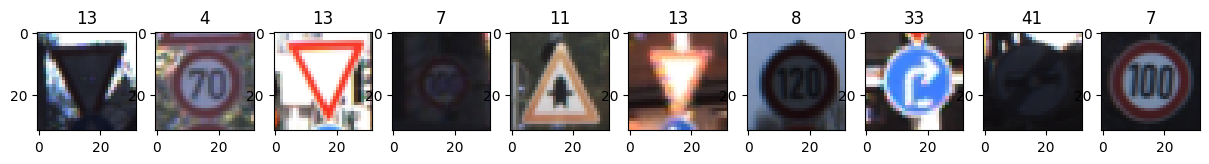

In [10]:
# Visualize random images from the training set
for x, y in train_loader:

    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')

    figure, axis = plt.subplots(1, 10, figsize=(15,15))

    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

We verify that the number of classes is 43 and that the number of images in the training and testing sets is 34799 and 12630 respectively.
- Since the number of classes is relatively large, we can try to group the classes into fewer categories to simplify the problem.
- We can also try to use data augmentation to increase the number of images in the training set. This will help the model generalize better and prevent overfitting.
- We can also note that the images have very different brightness and contrast levels. We should try to normalize the images to make the model more robust to these variations.

# Data Distribution

In [11]:
def plot_distrib(data_path: str, title: str):
    # Load data from the .npy file
    data = np.load(data_path)

    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(data, columns=['Labels'])

    # Plot the distribution using Plotly Express
    fig = px.histogram(df, x='Labels', title=title)
    fig.show()

# Plot distribution for train labels
plot_distrib(data_path='cache/train_labels.npy', title="Training samples distribution")

# Plot distribution for test labels
plot_distrib(data_path='cache/test_labels.npy', title="Testing samples distribution")


There is a lot of imbalance between classes, for example, class 0, 19, 32 and others have very few images, close to 60, whilst others like 2 and 38 have close to 750. If this imbalance leads to poor performance, we can try some techniques to improve the data:
- Augmenting the classes with fewer images by rotating, changing colors, cropping to have more data
- Applying class weights to the loss function to penalize the model more when it makes mistakes on the classes with fewer images
- Reduce the number of classes by creating more general categories - This is not what we intend to do as it differs from our goal of recognizing the traffic signs as they are, but it is an option if the model is not performing well

# **Model 1 - Without any Data Augmentation**




In [12]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=43):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.LeakyReLU(0.01)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.LeakyReLU(0.01)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(512)
        self.relu3 = nn.LeakyReLU(0.01)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.25)

        self.fc1 = nn.Linear(512*4*4, 128)
        self.relu4 = nn.LeakyReLU(0.01)
        self.dropout4 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = x.view(-1, 512*4*4)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.fc2(x)
        return x

In [13]:
def train(model, train_loader, test_loader, epochs, loss_fn, optimizer):

    history = {}
    history['accuracy'] = []
    history['test_acc'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time()
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):

            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)

            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        t_correct = 0
        with torch.no_grad():
            for i,t in test_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)

                t_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Test_Acc: {t_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')

    return(history)

In [14]:
model_I = CNN()
model_I.to(device)

summary(model_I, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer_I = torch.optim.Adam(model_I.parameters())

history = train(model_I, train_loader, test_loader, EPOCHS, criterion, optimizer_I)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           9,728
       BatchNorm2d-2          [-1, 128, 28, 28]             256
         LeakyReLU-3          [-1, 128, 28, 28]               0
         Dropout2d-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 256, 24, 24]         819,456
       BatchNorm2d-6          [-1, 256, 24, 24]             512
         LeakyReLU-7          [-1, 256, 24, 24]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
         Dropout2d-9          [-1, 256, 12, 12]               0
           Conv2d-10            [-1, 512, 8, 8]       3,277,312
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
        LeakyReLU-12            [-1, 512, 8, 8]               0
        MaxPool2d-13            [-1, 512, 4, 4]               0
        Dropout2d-14            [-1, 51

## Results

<!-- The model had decent results for being the first model without any data augmentation. The accuracy on the test set was 0.95 but there are some notes to be made:

- Many of the danger signs were missclassified between them, might be due to the extremely poor quality of some of the images, so we might need to preprocess the images more to make them more uniform, adding noise and random marks to the images to make the model more robust to these variations.
- The same can be said for the speed limit signs, being missclassified as other speeds -->

In [15]:
torch.save({
        'model_I':model_I.state_dict(),
        'optimizer_I': optimizer_I.state_dict()
        },
        os.path.join(MODEL_PATH, 'model_I.pt'))

best_train = np.asarray(history['accuracy']).argmax()
best_test = np.asarray(history['test_acc']).argmax()

print('Best epoch for train accuracy: :', best_train,' Best epoch for test accuracy: :',  best_test)
print('Test accuracy at epoch ',best_train, ' :', history['test_acc'][best_train], 'Test accuracy at epoch ',best_test, ' :', history['test_acc'][best_test])

Best epoch for train accuracy: : 7  Best epoch for test accuracy: : 7
Test accuracy at epoch  7  : 97.79889 Test accuracy at epoch  7  : 97.79889


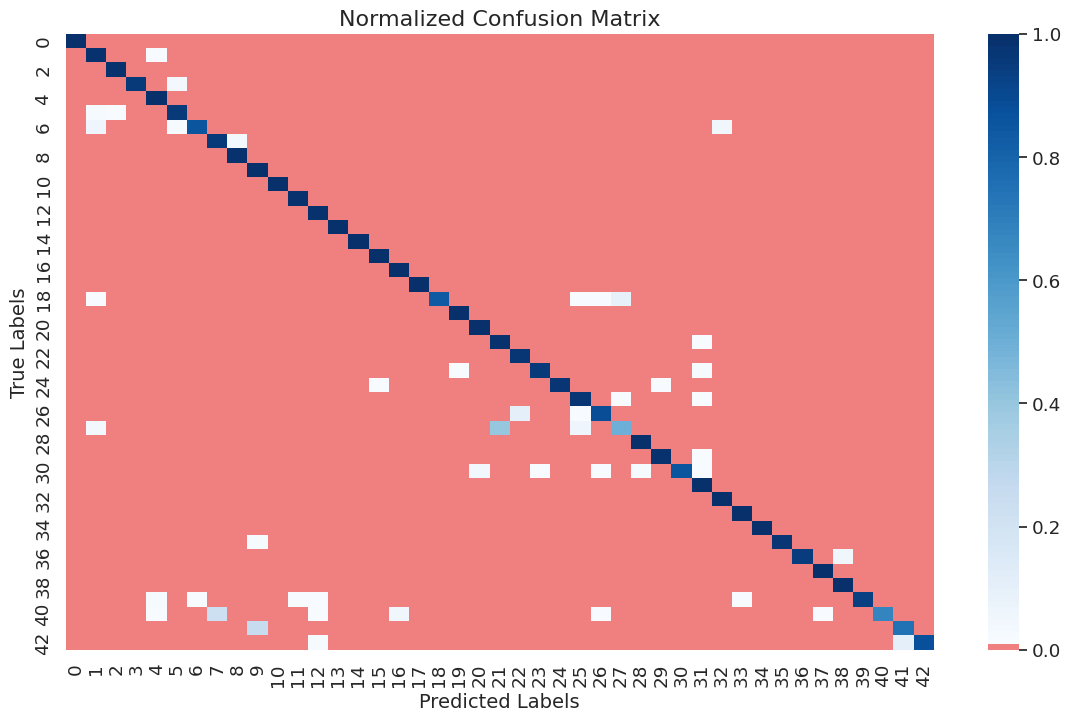

In [16]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model_I(images.to(device))
    preds_sparse = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_sparse)
    ground_truth.extend(targets.numpy())

# Access class_to_idx from the original dataset instead of the subset
show_confusion_matrix(ground_truth, preds, len(train_dataset.class_to_idx))


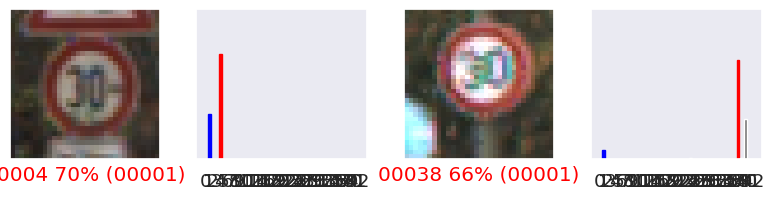

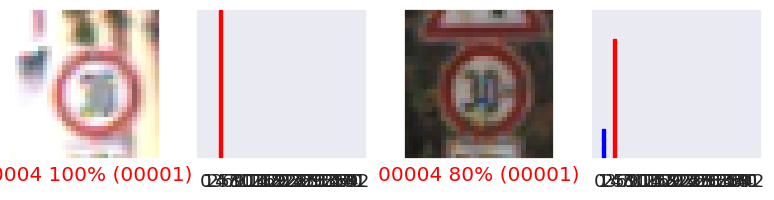

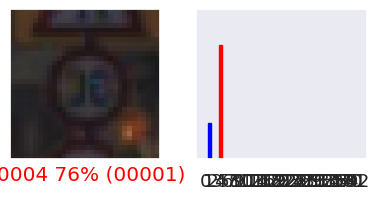

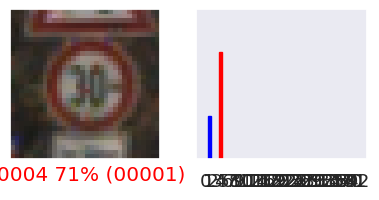

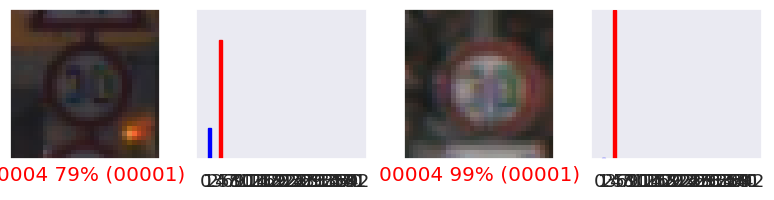

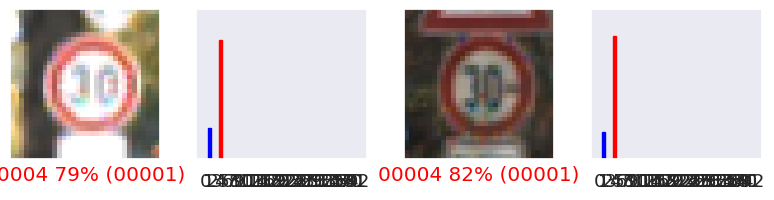

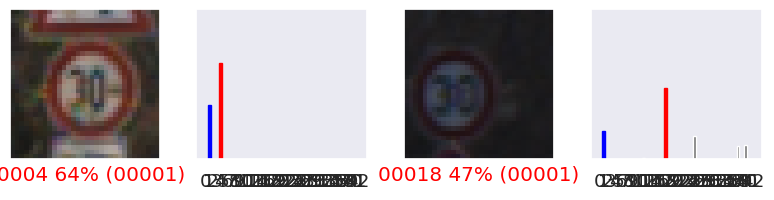

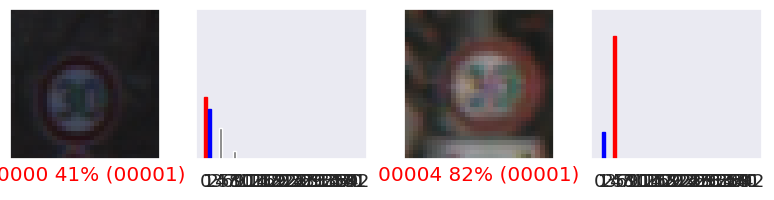

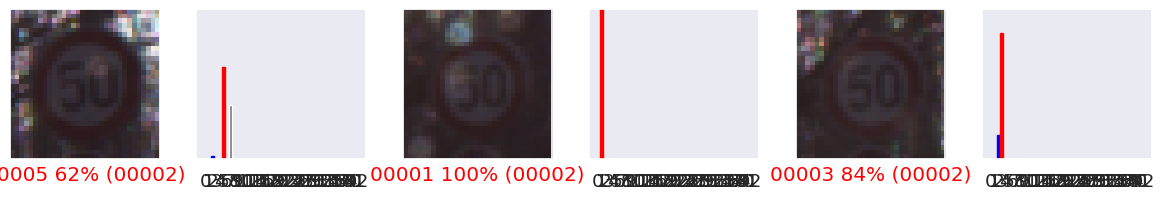

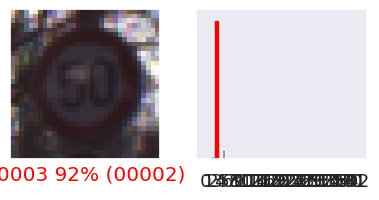

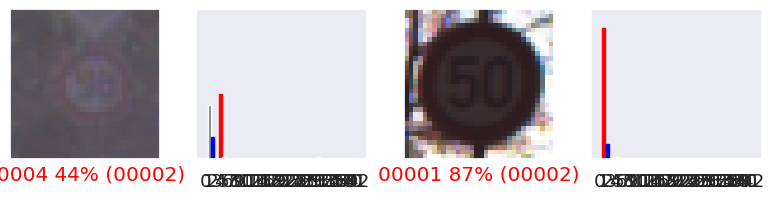

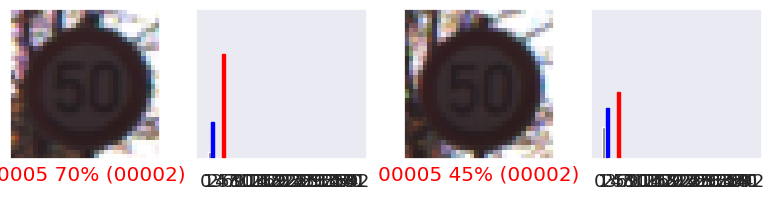

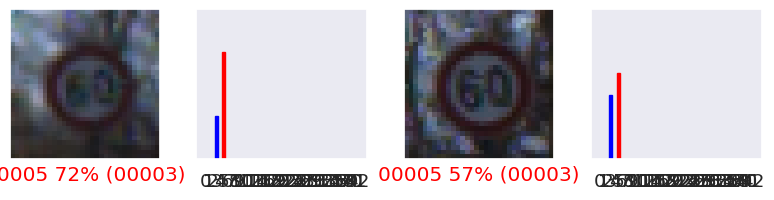

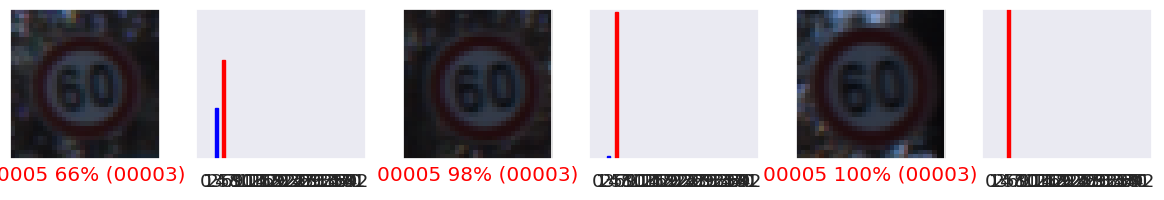

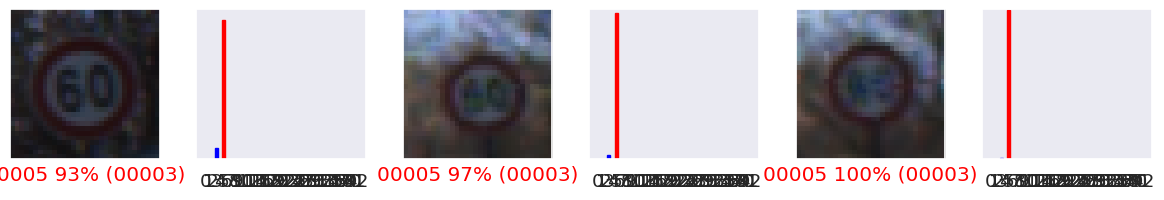

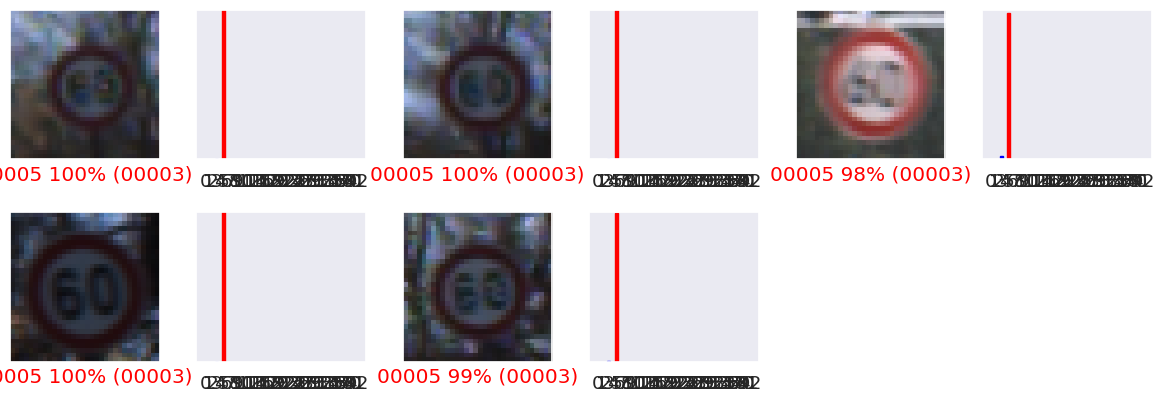

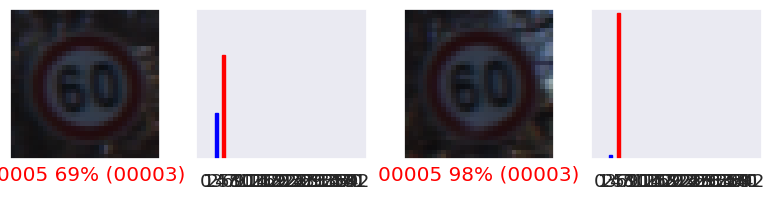

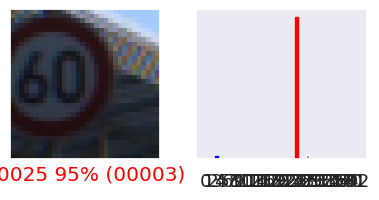

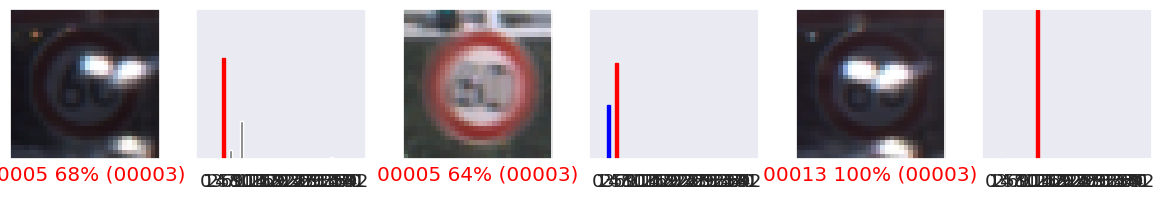

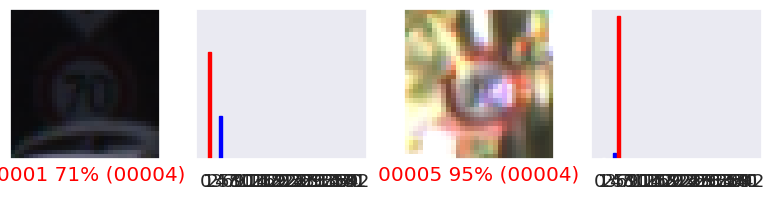

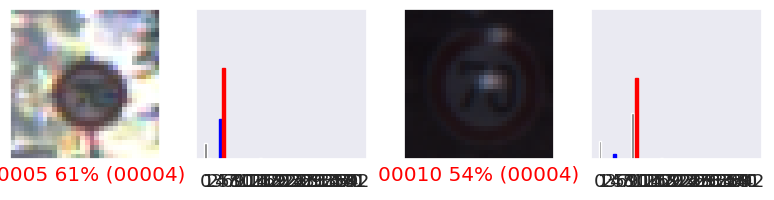

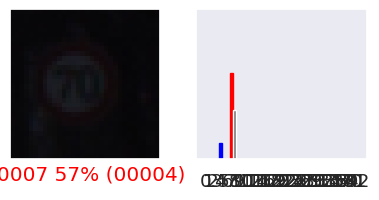

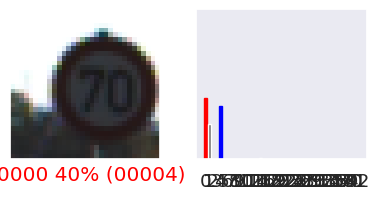

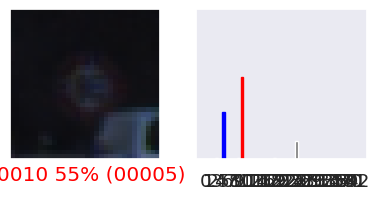

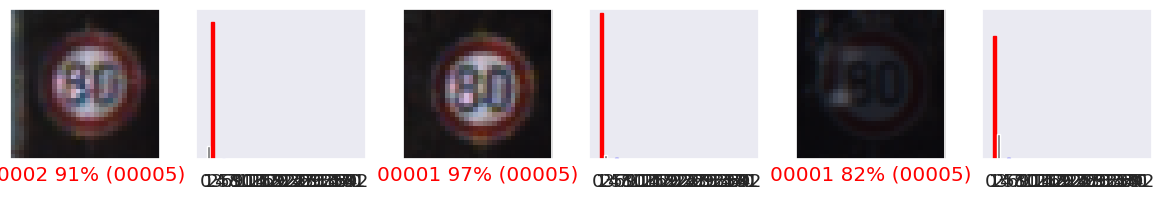

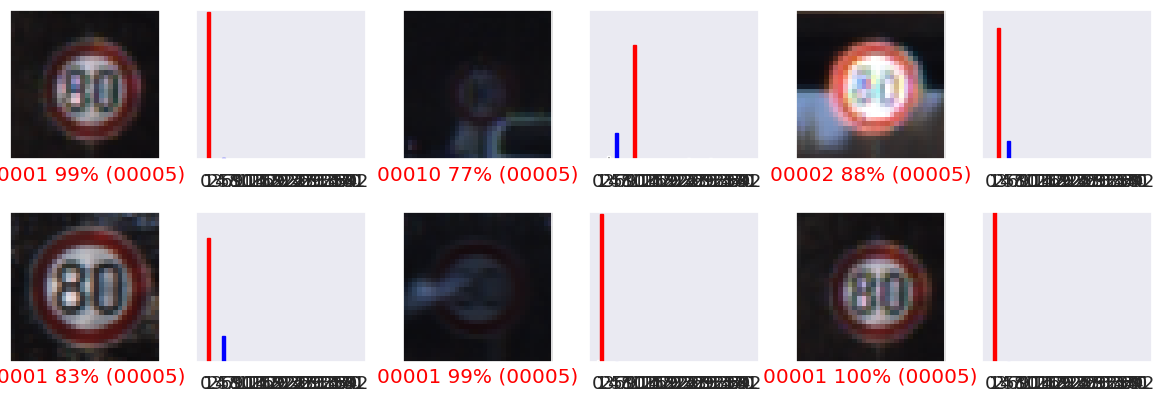

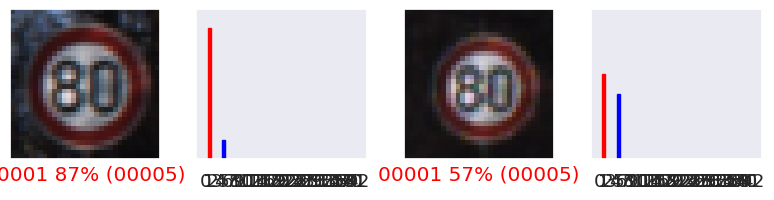

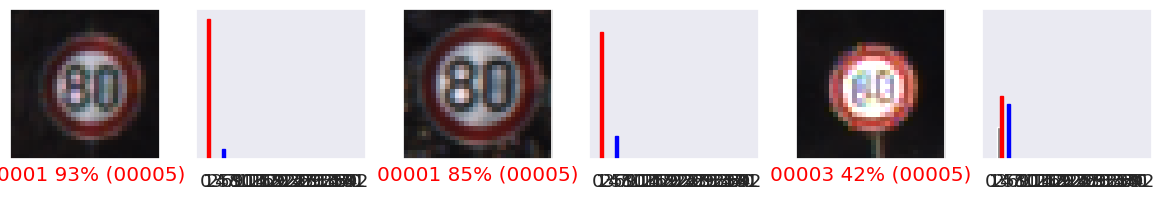

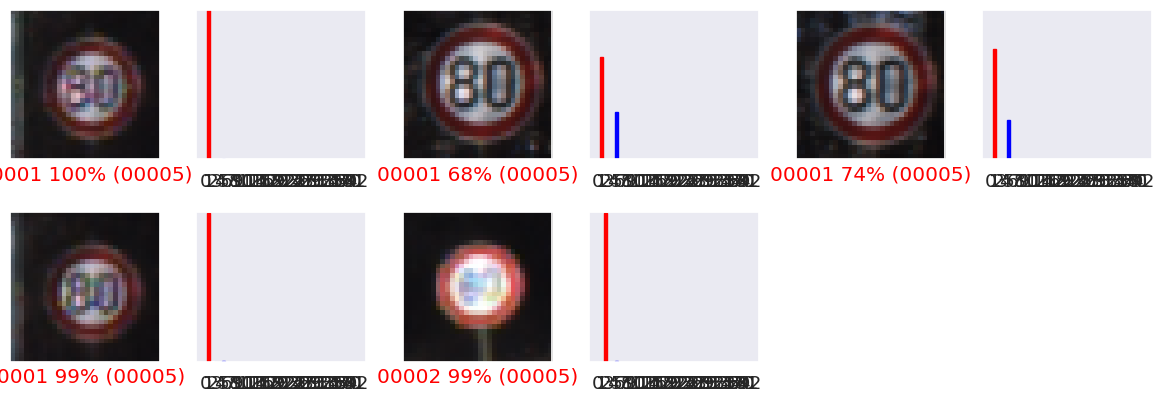

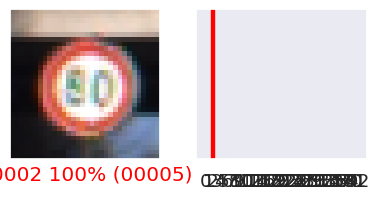

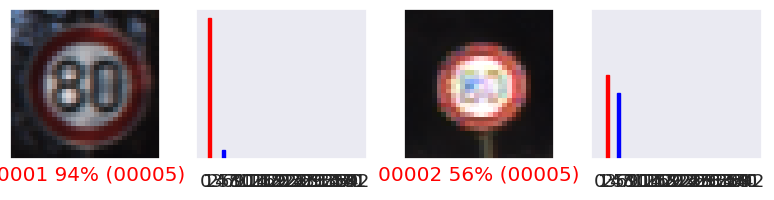

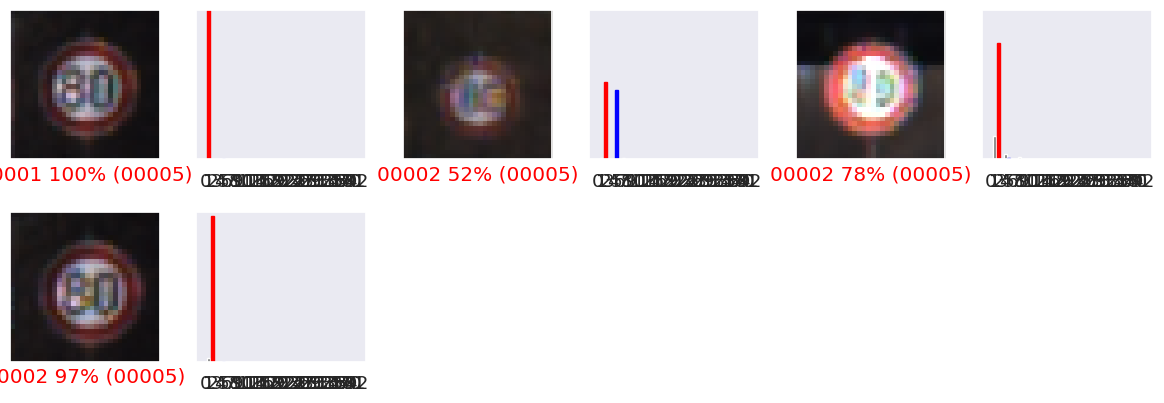

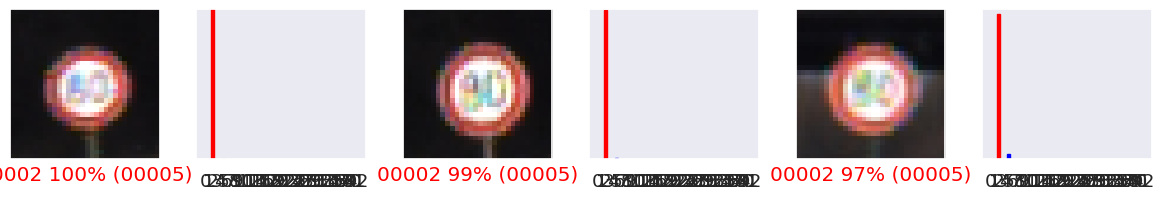

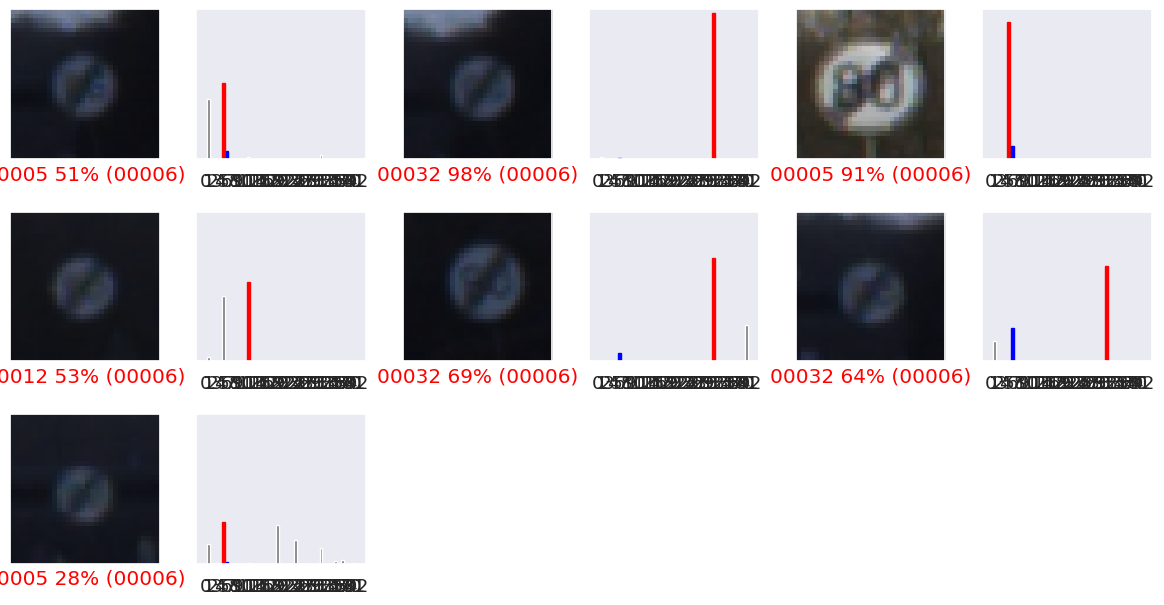

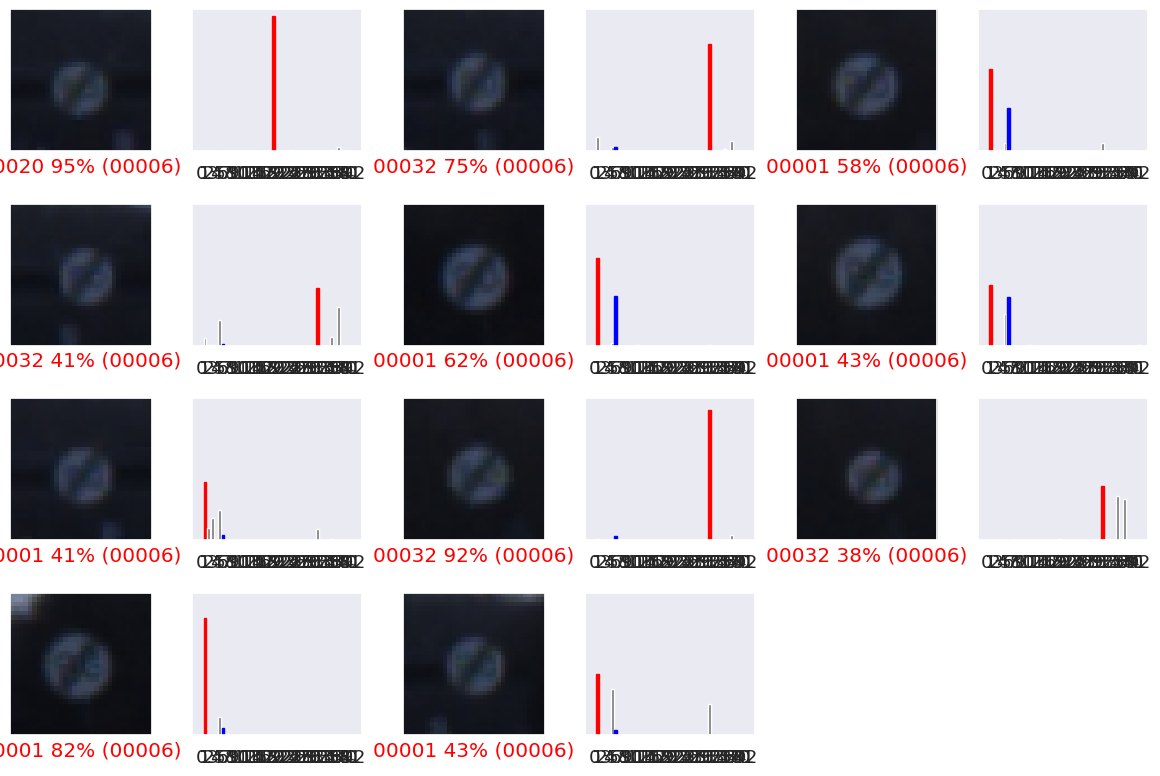

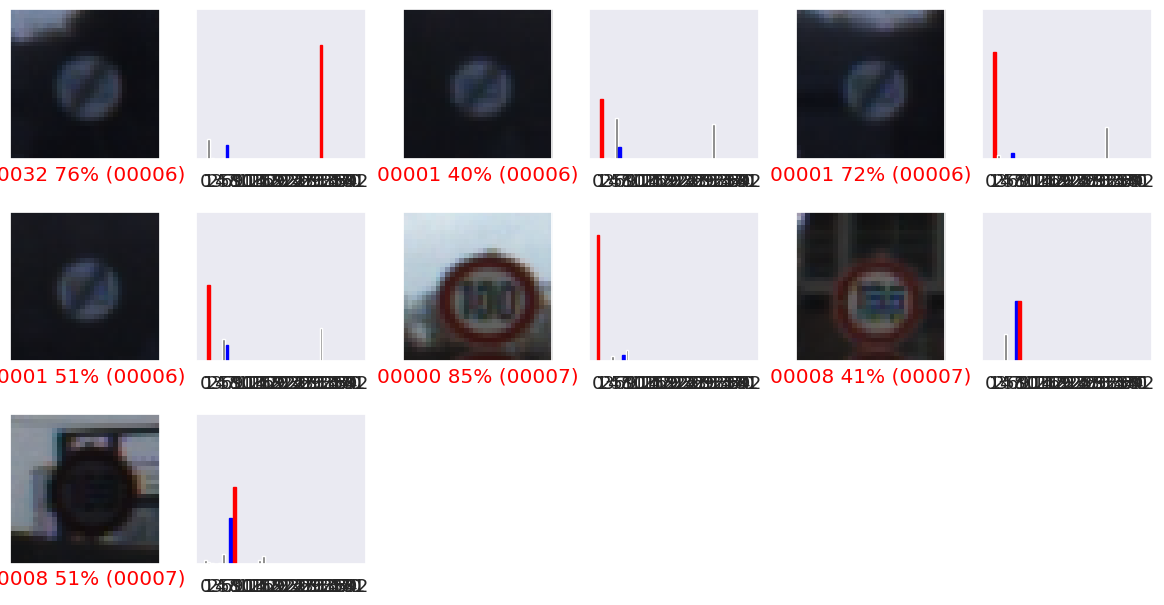

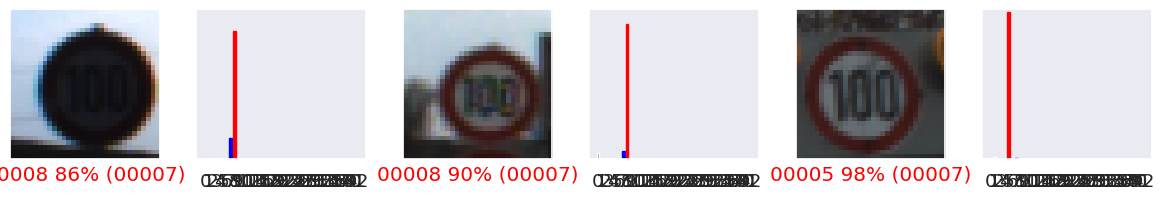

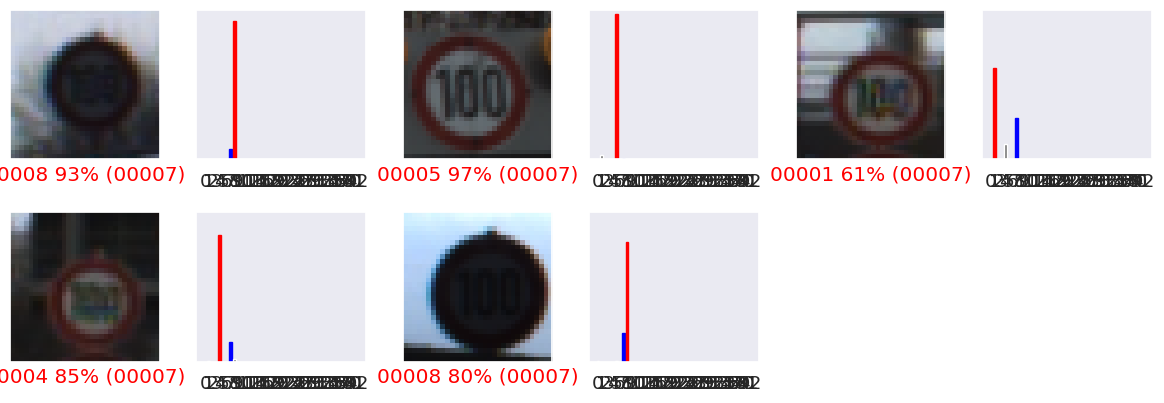

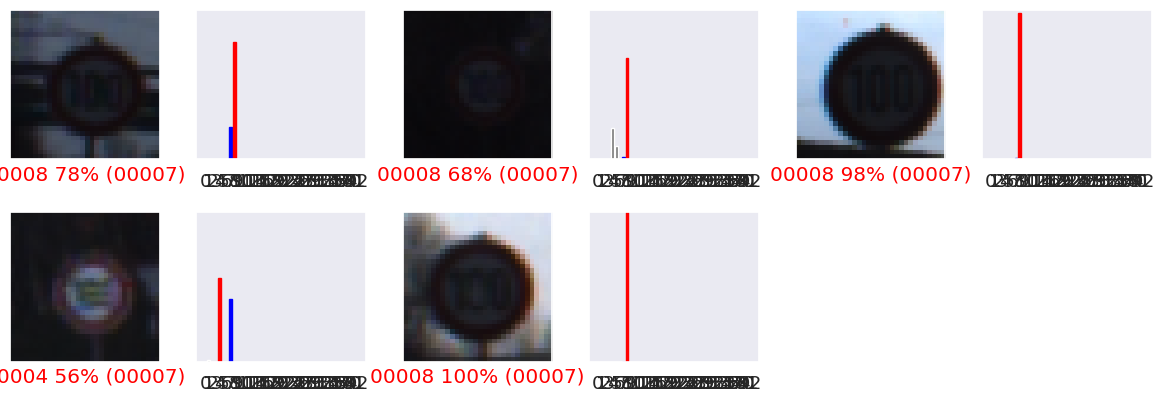

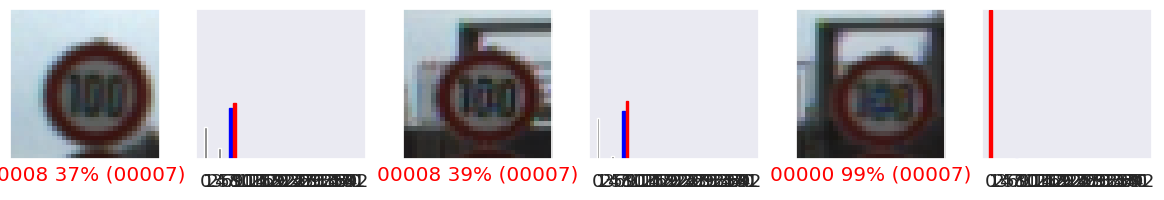

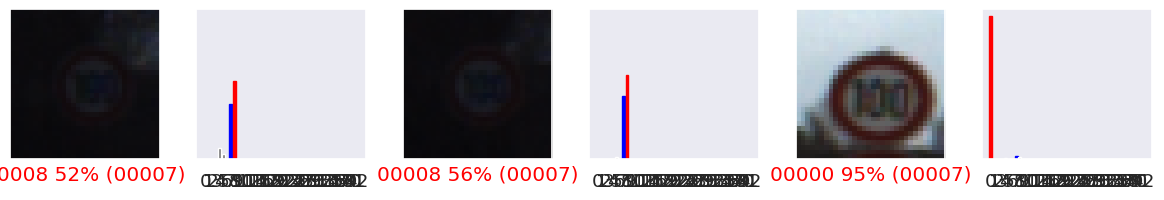

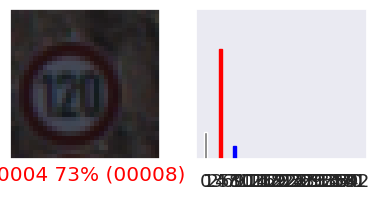

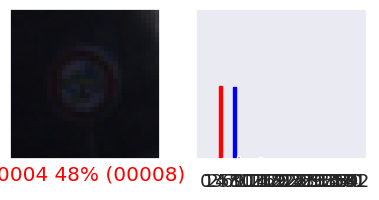

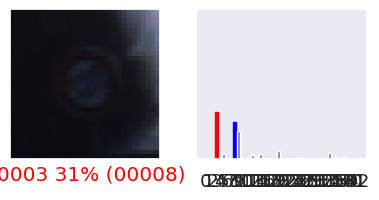

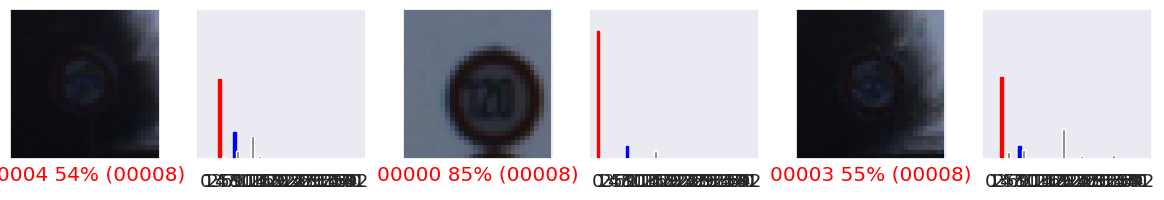

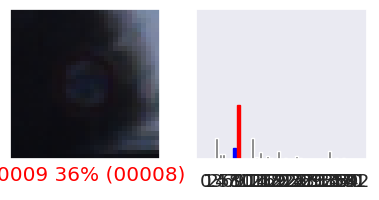

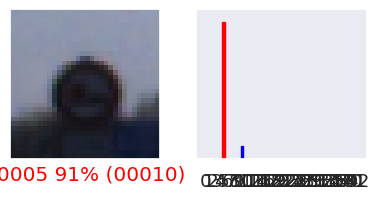

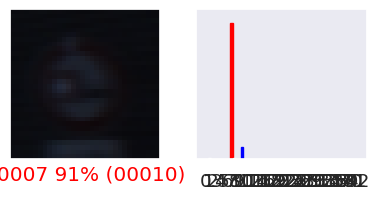

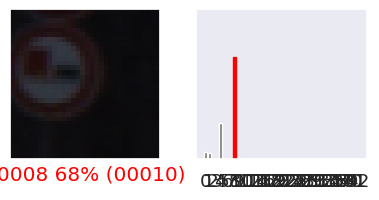

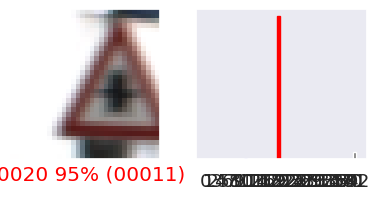

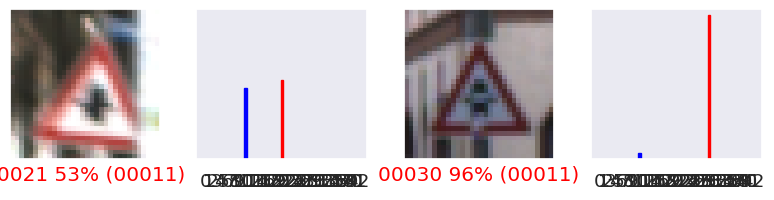

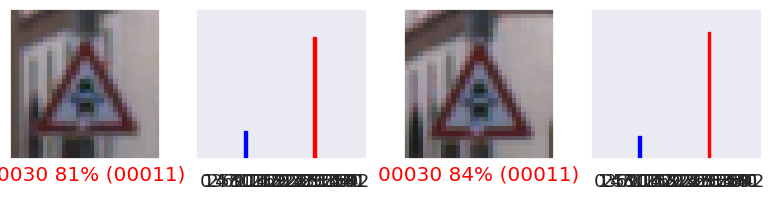

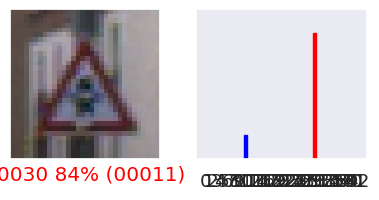

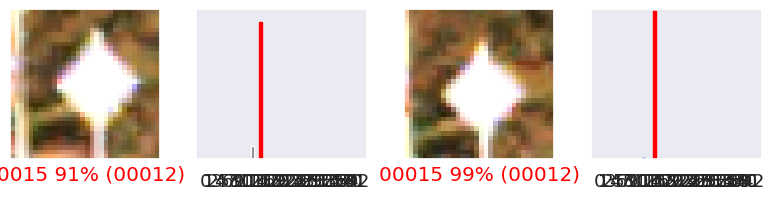

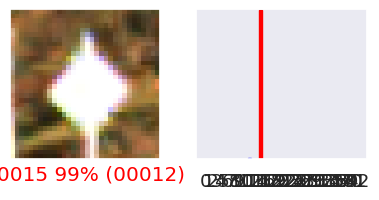

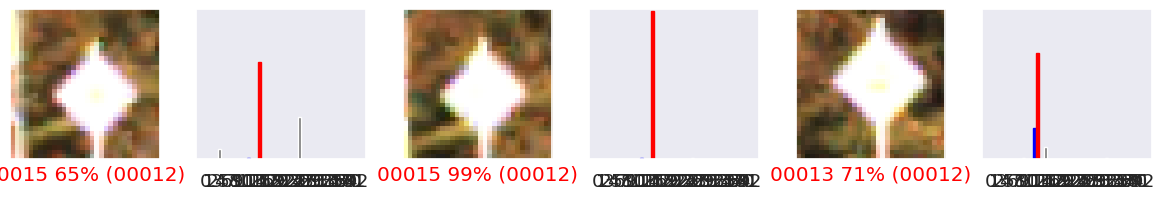

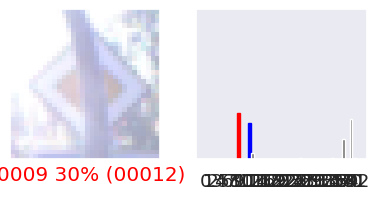

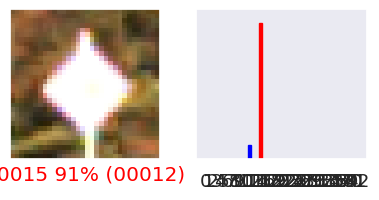

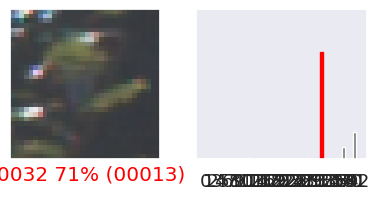

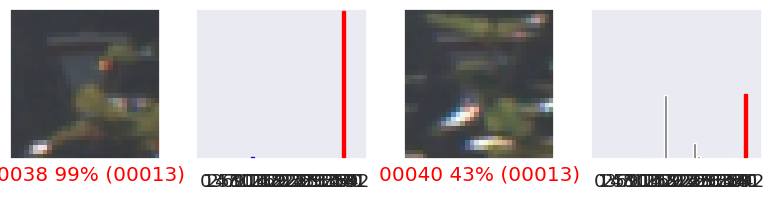

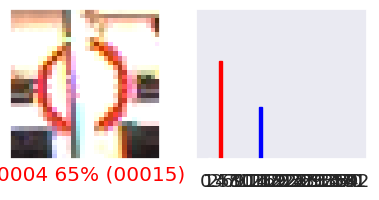

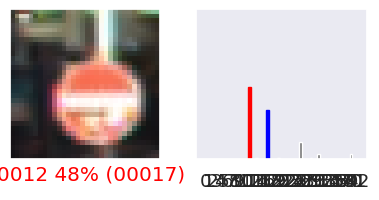

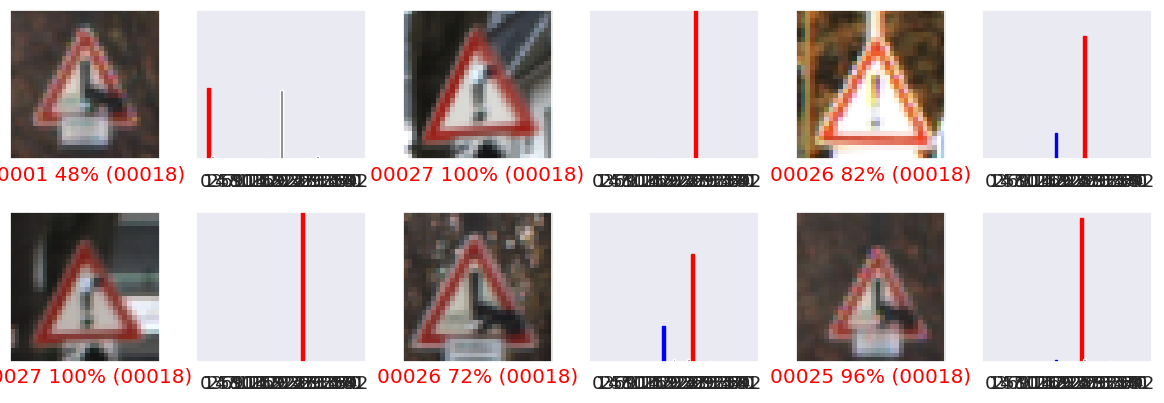

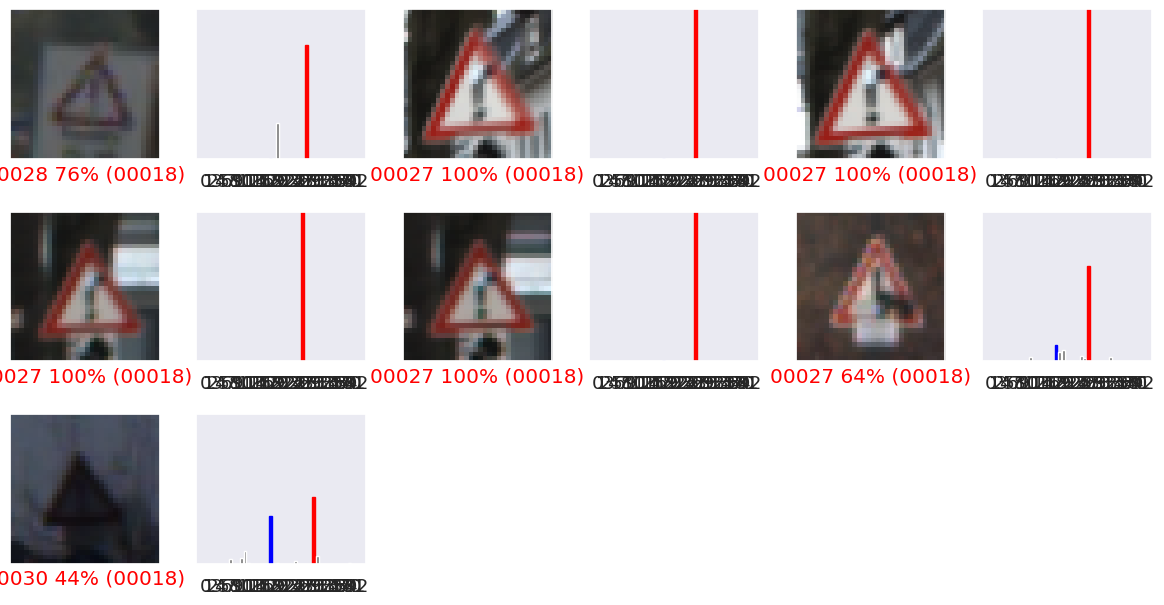

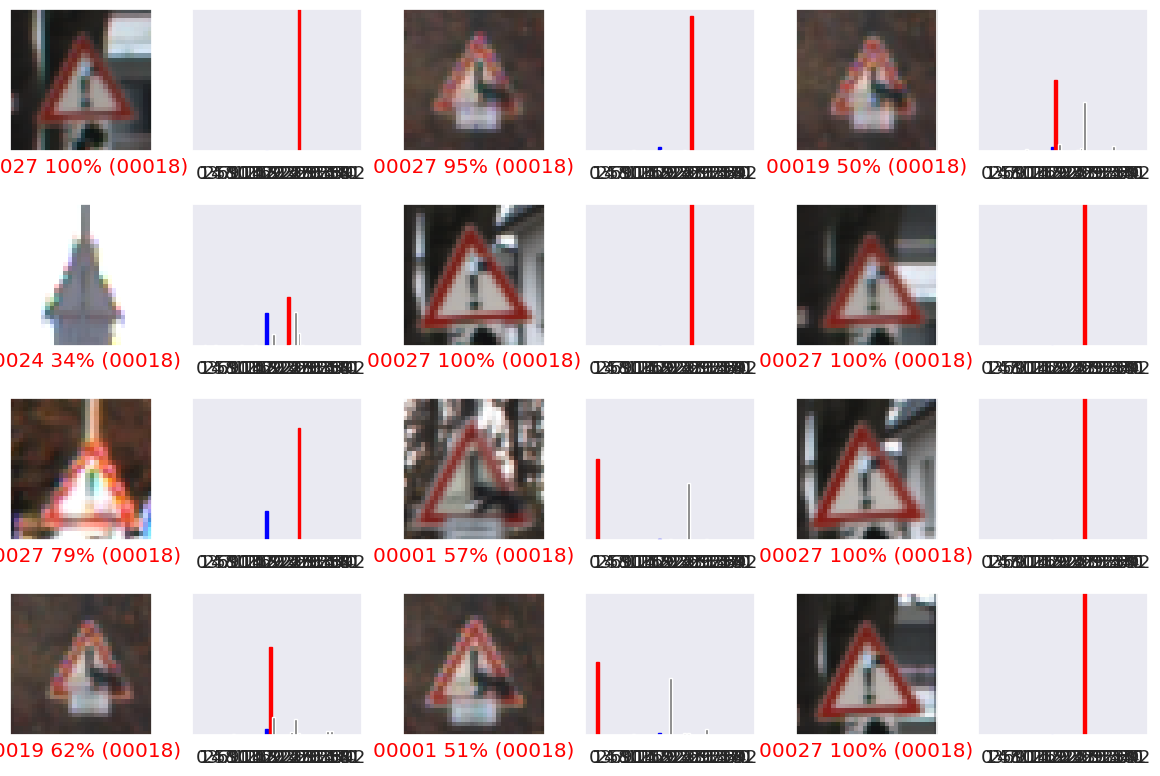

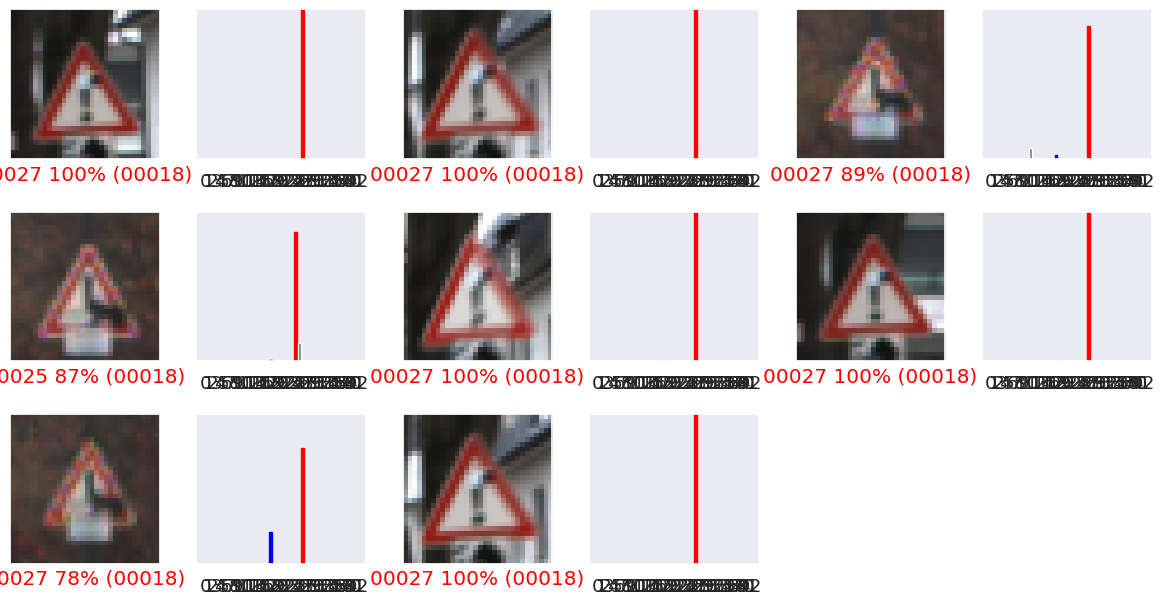

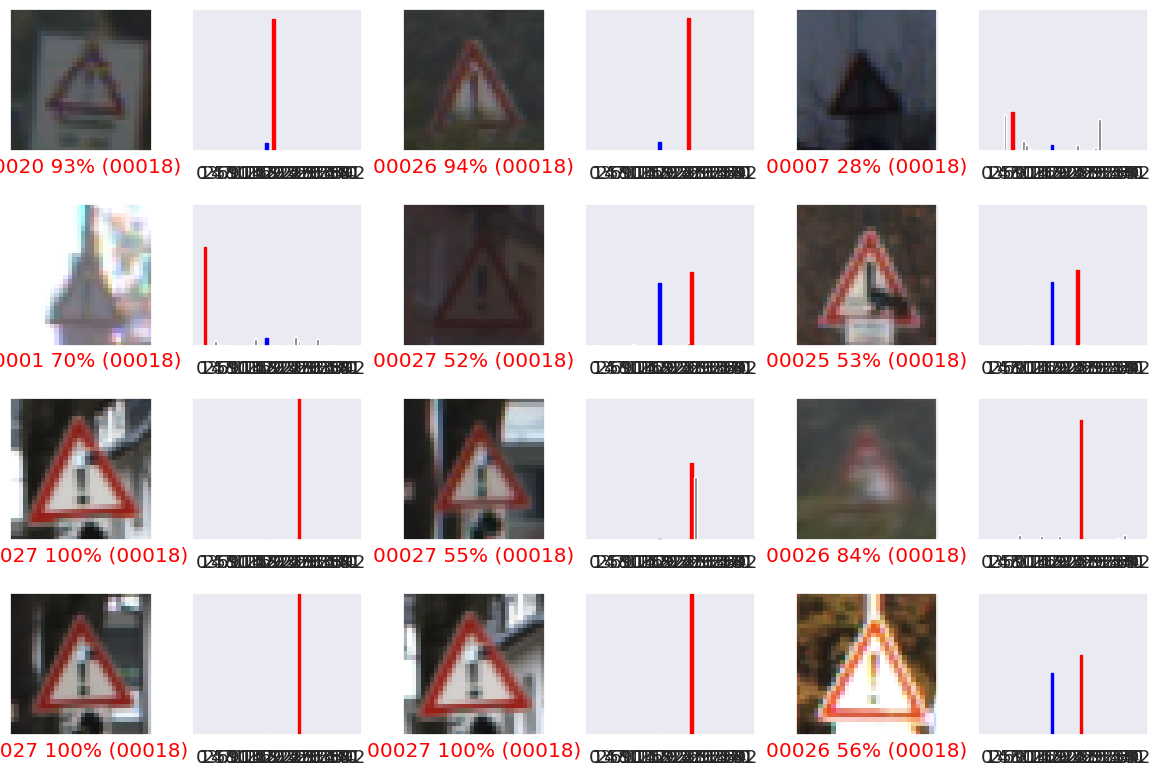

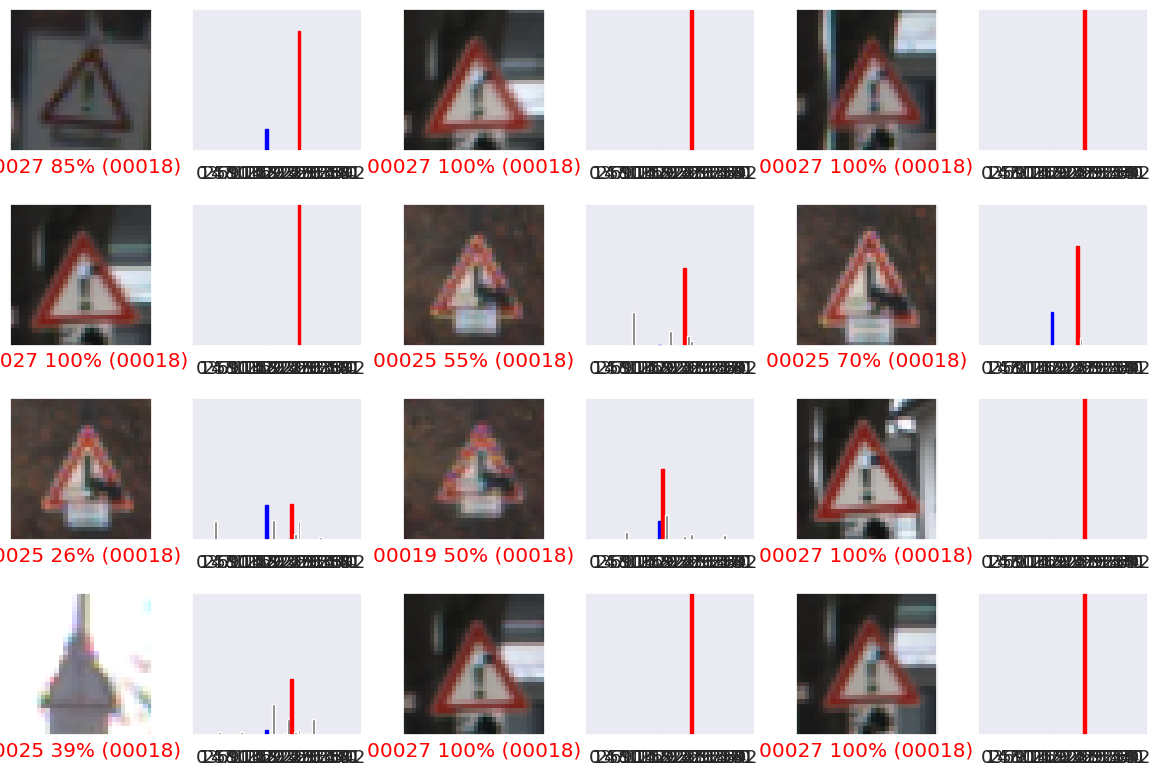

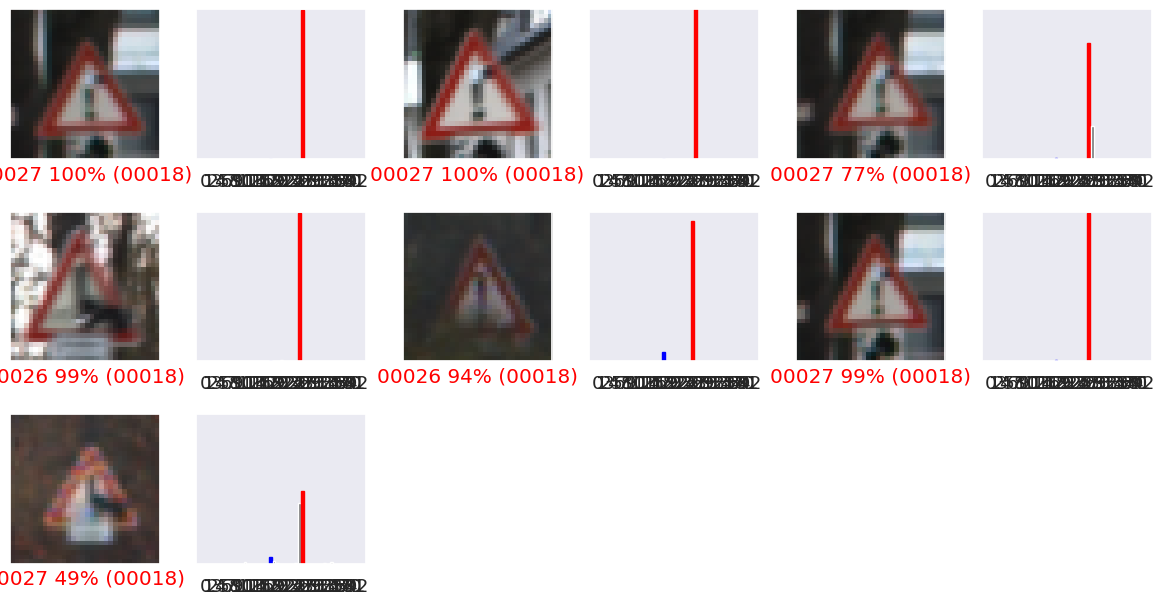

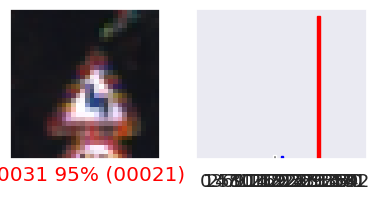

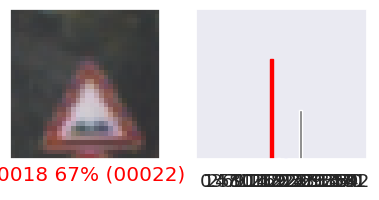

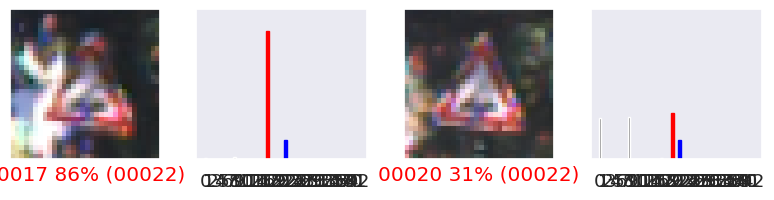

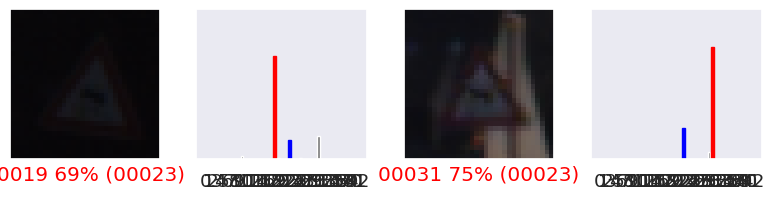

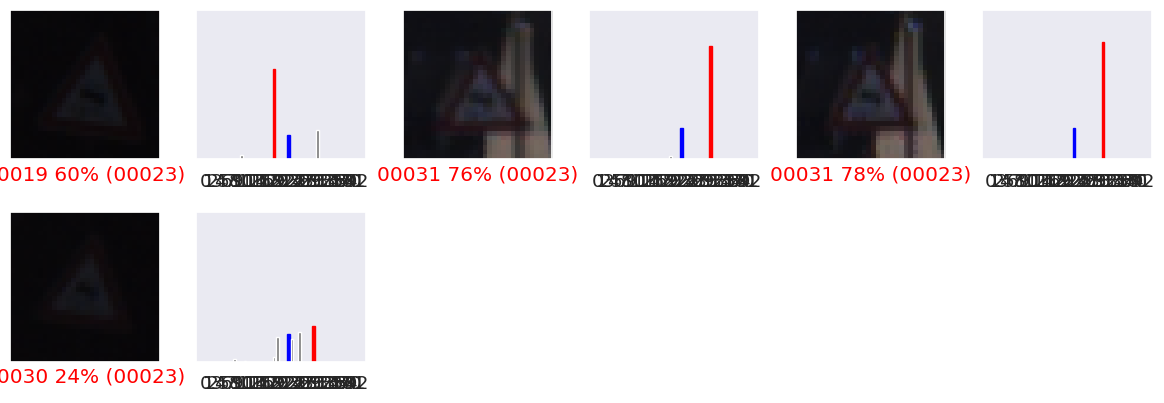

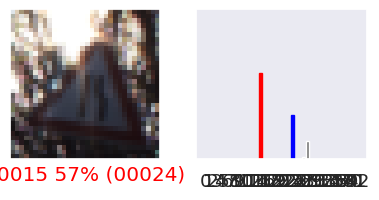

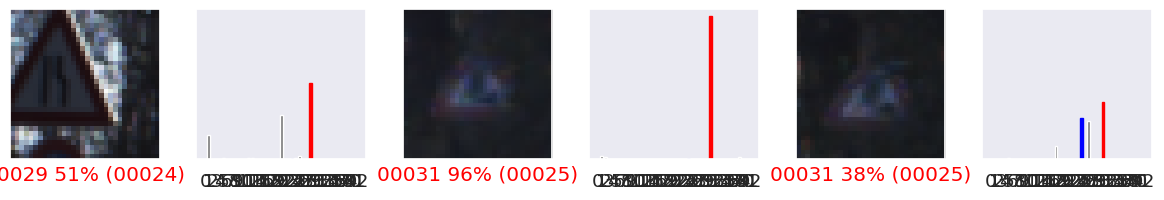

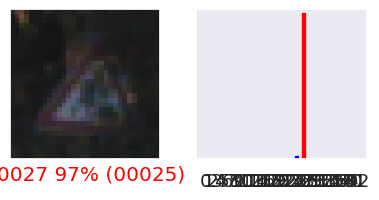

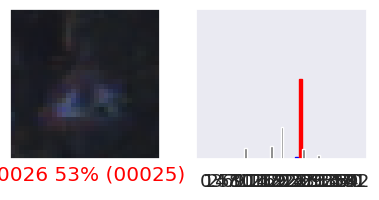

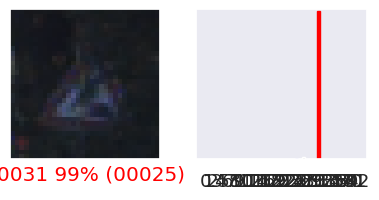

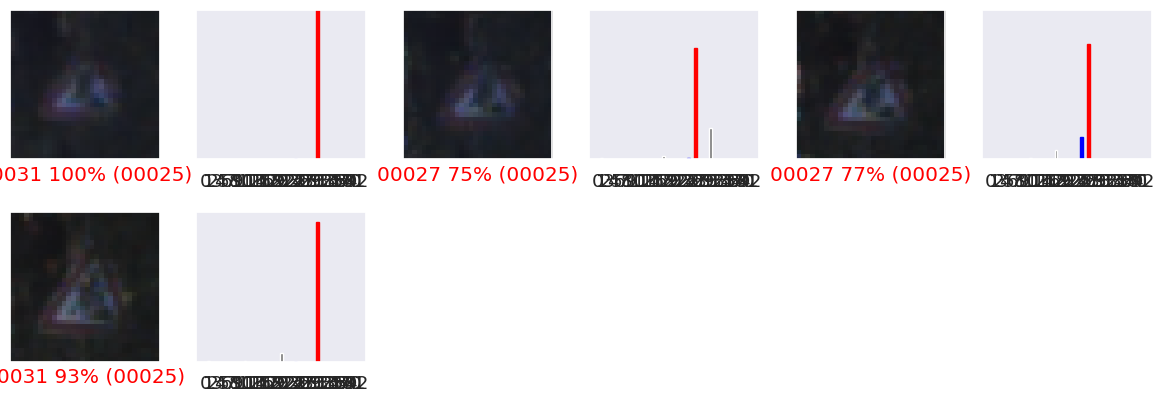

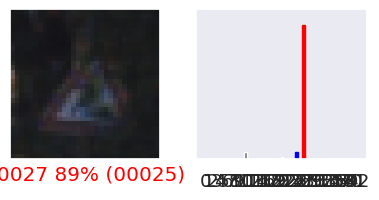

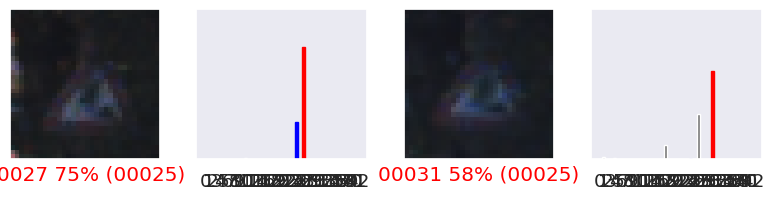

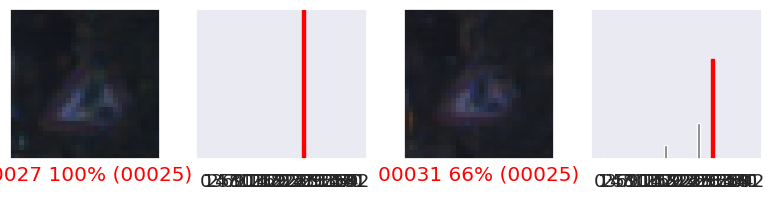

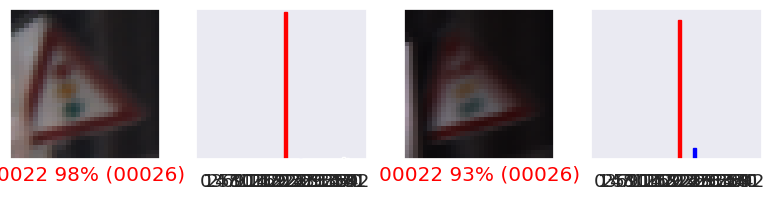

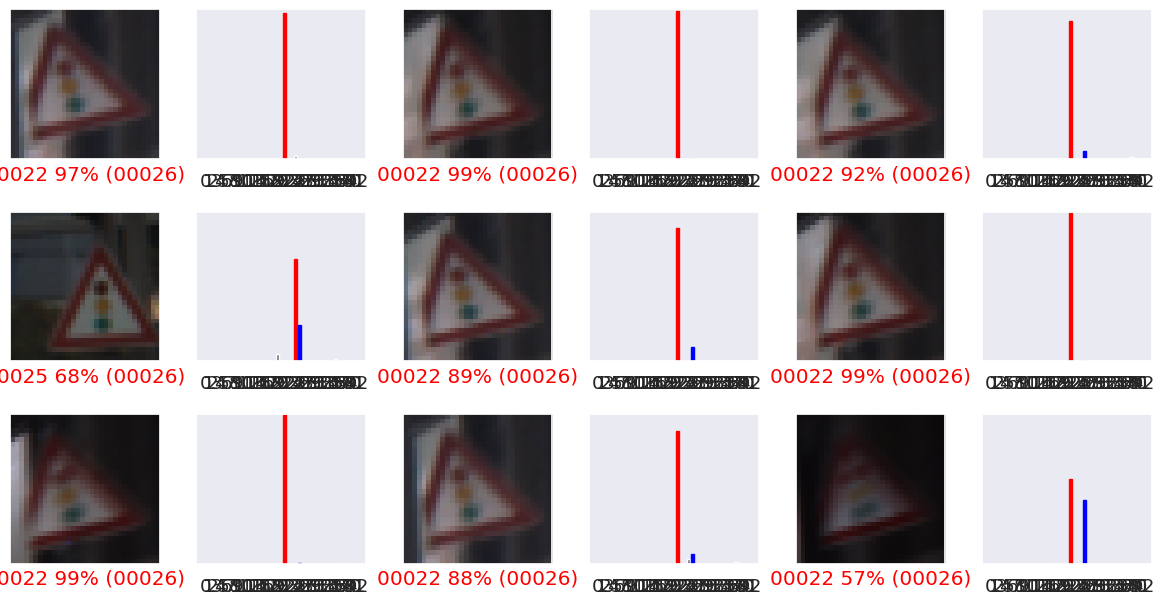

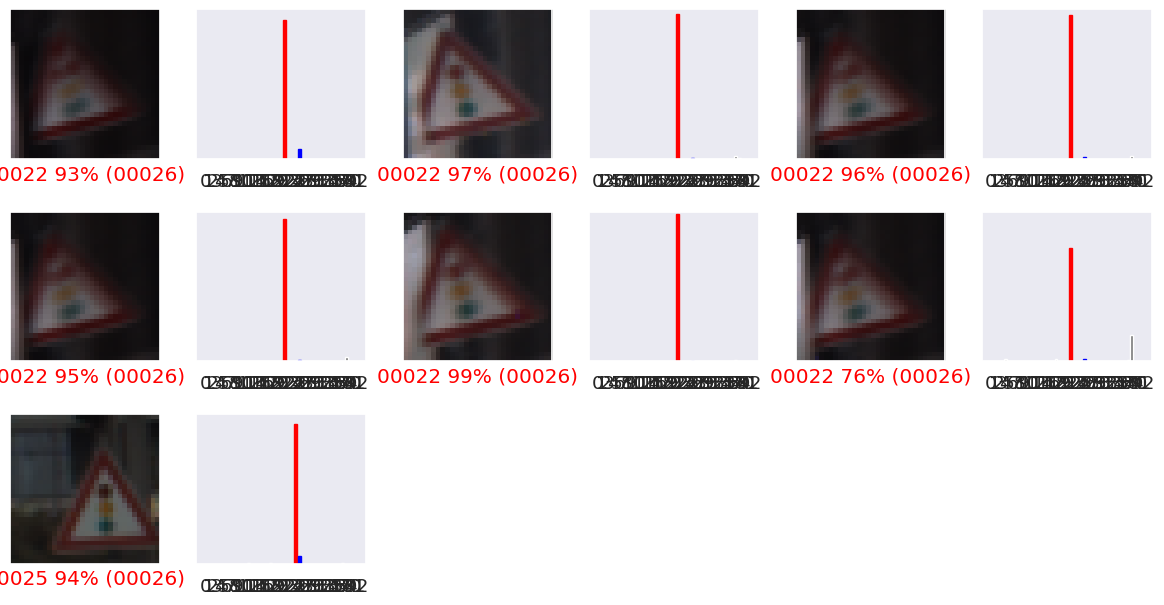

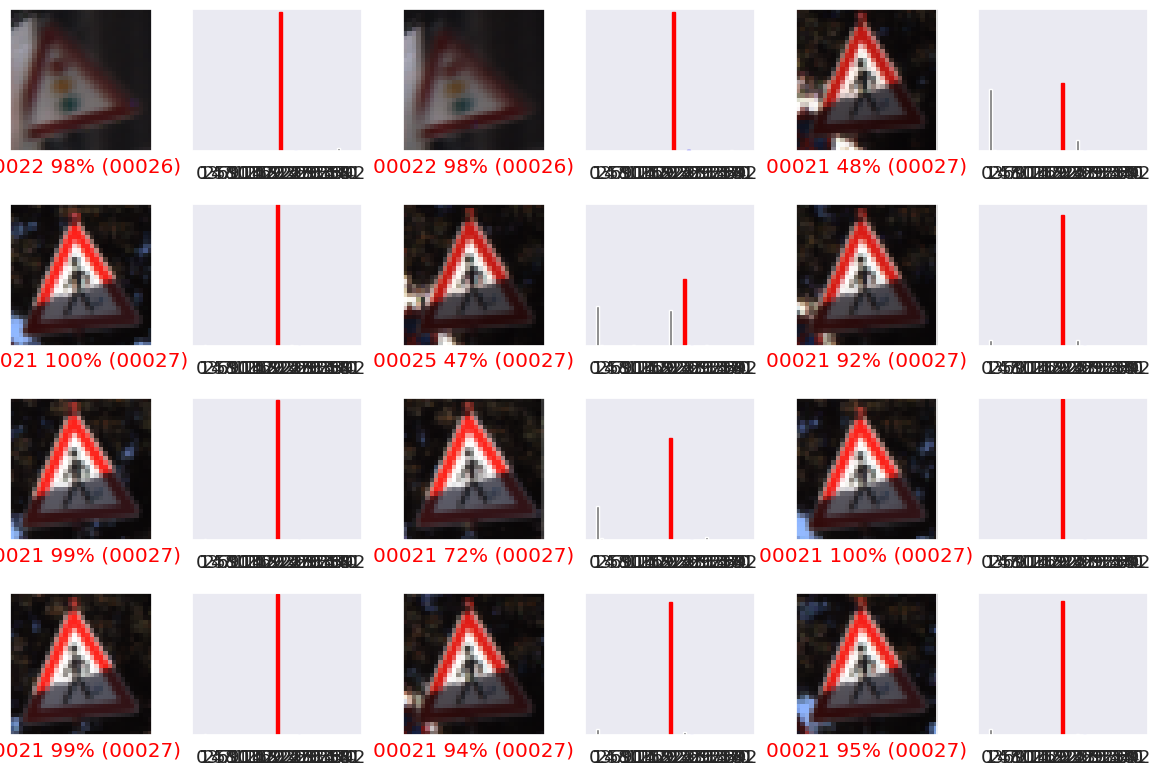

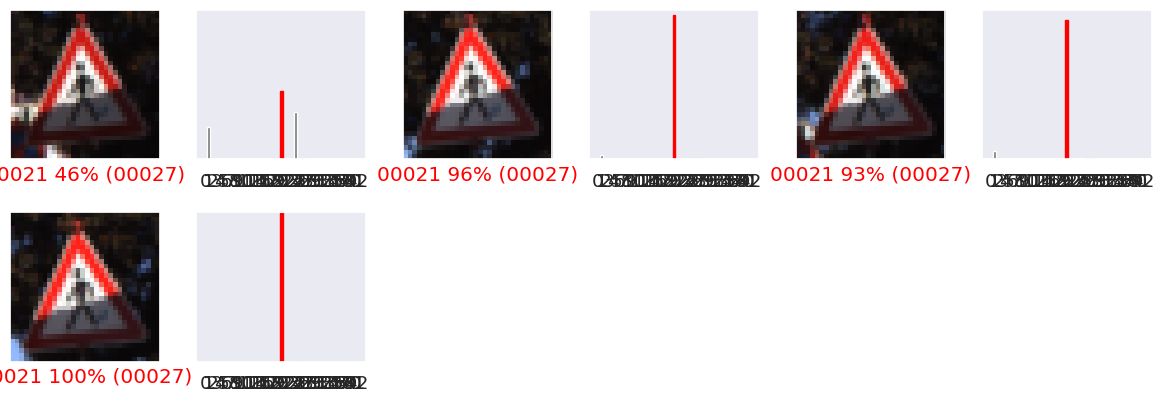

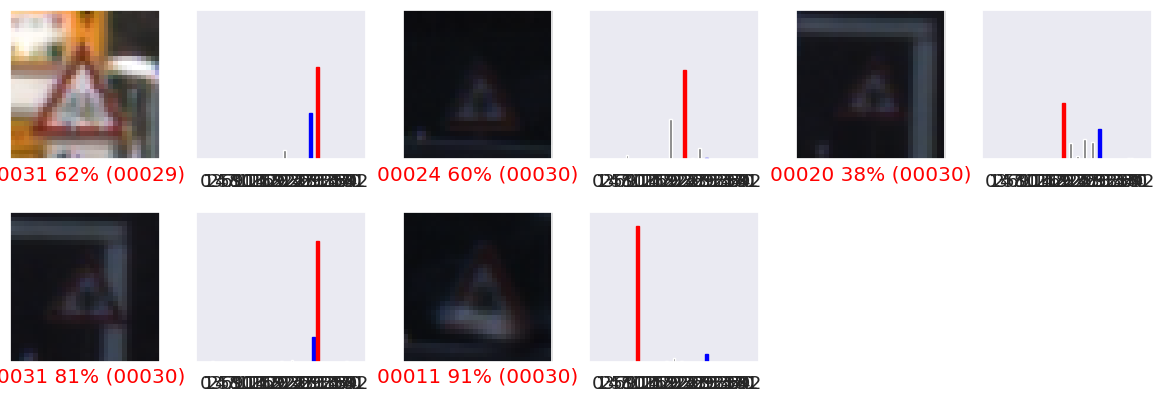

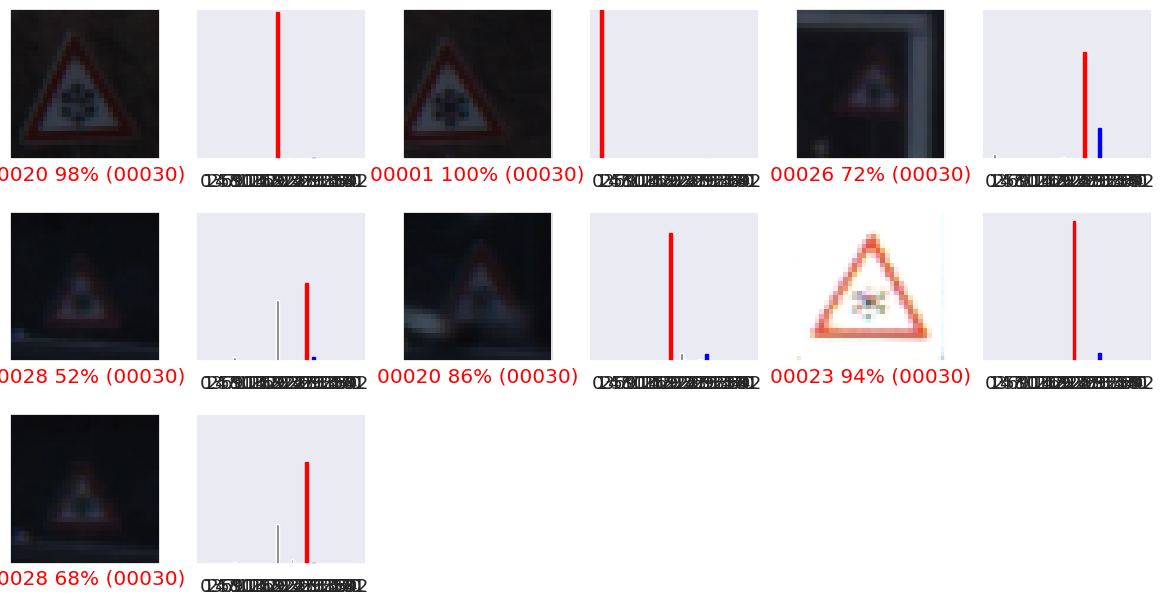

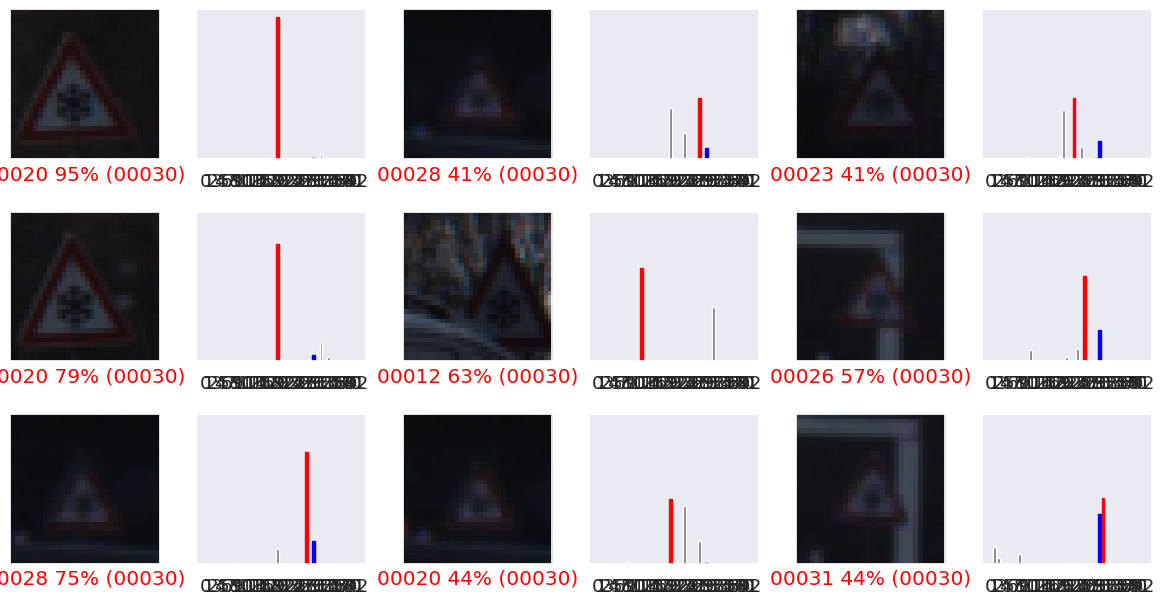

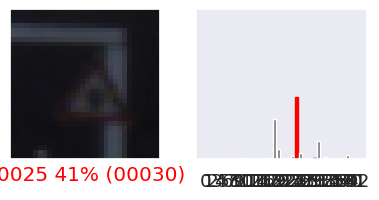

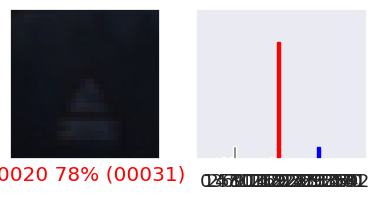

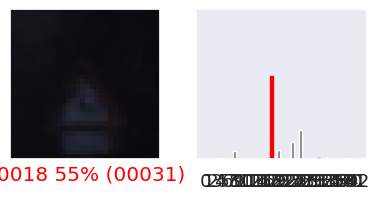

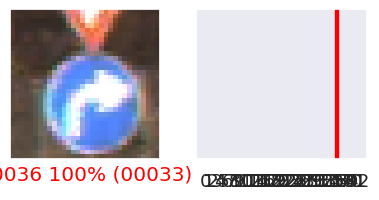

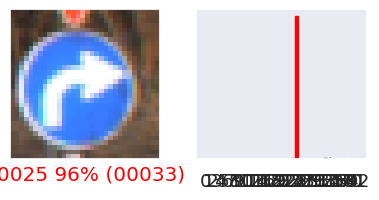

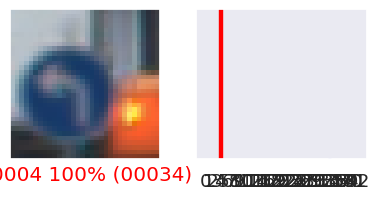

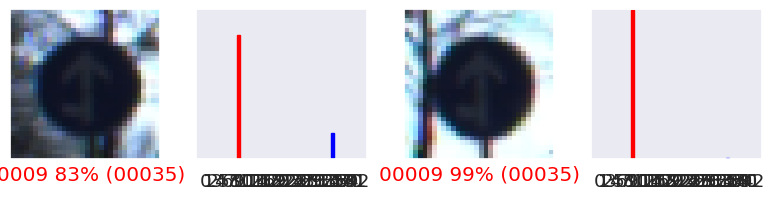

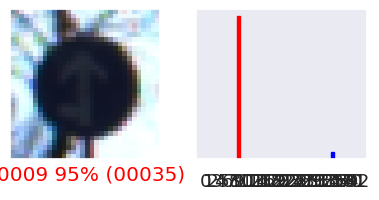

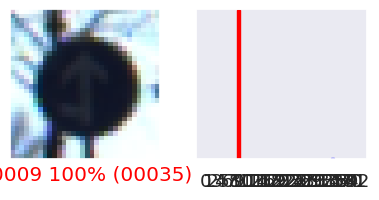

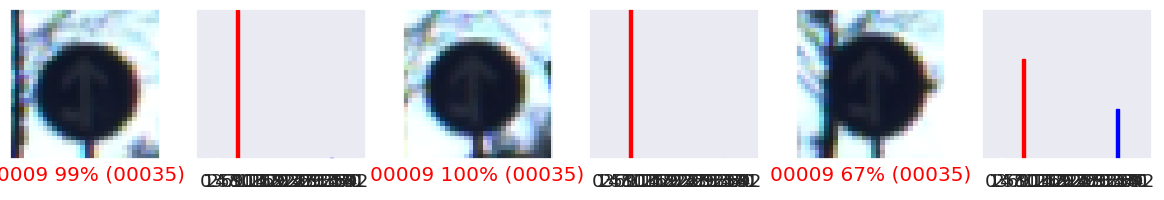

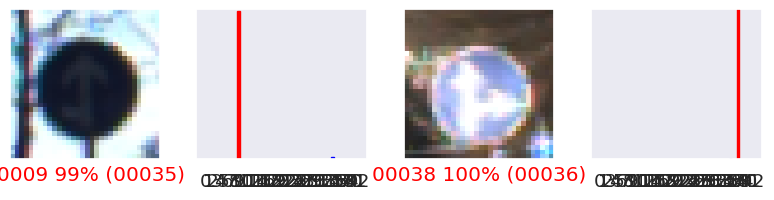

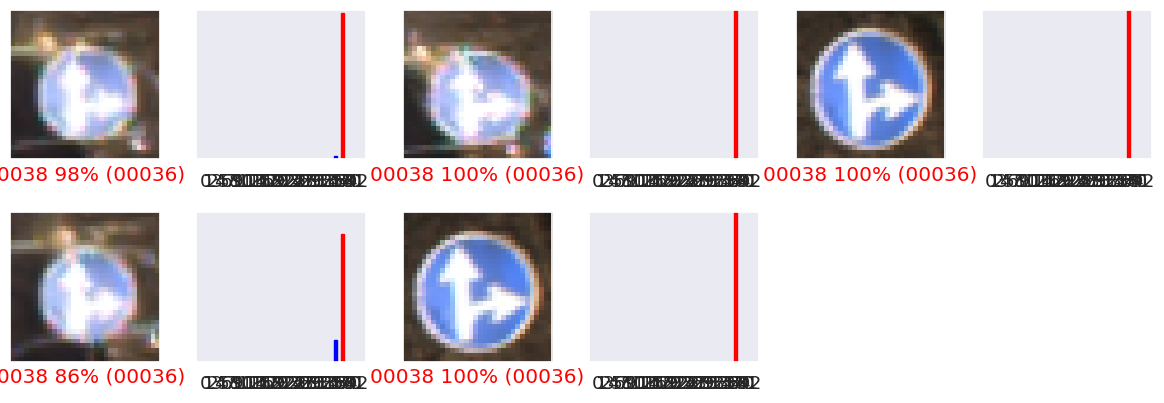

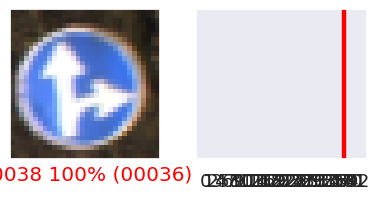

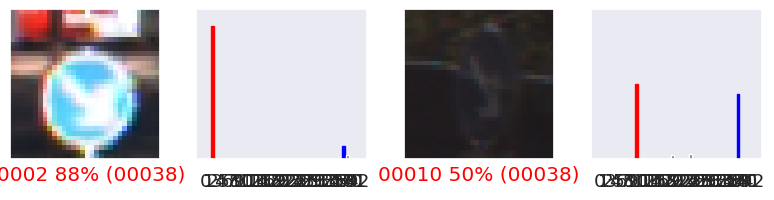

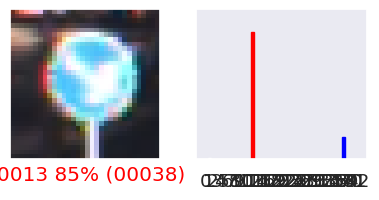

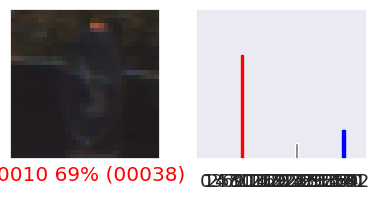

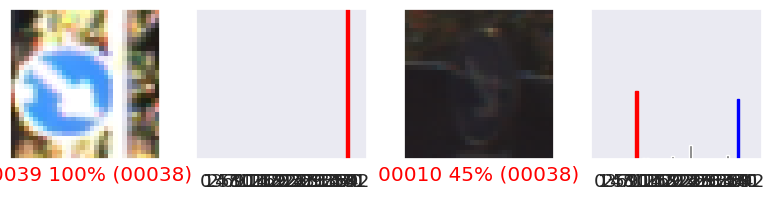

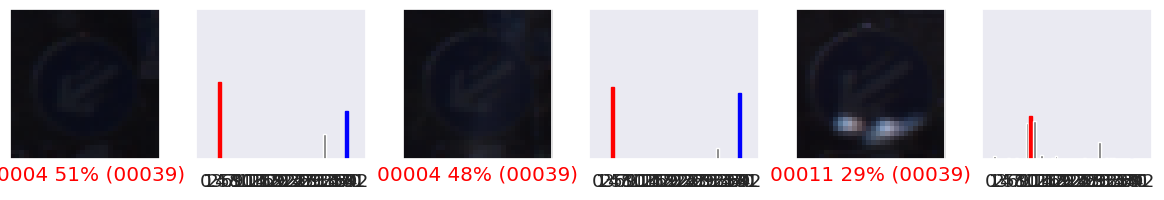

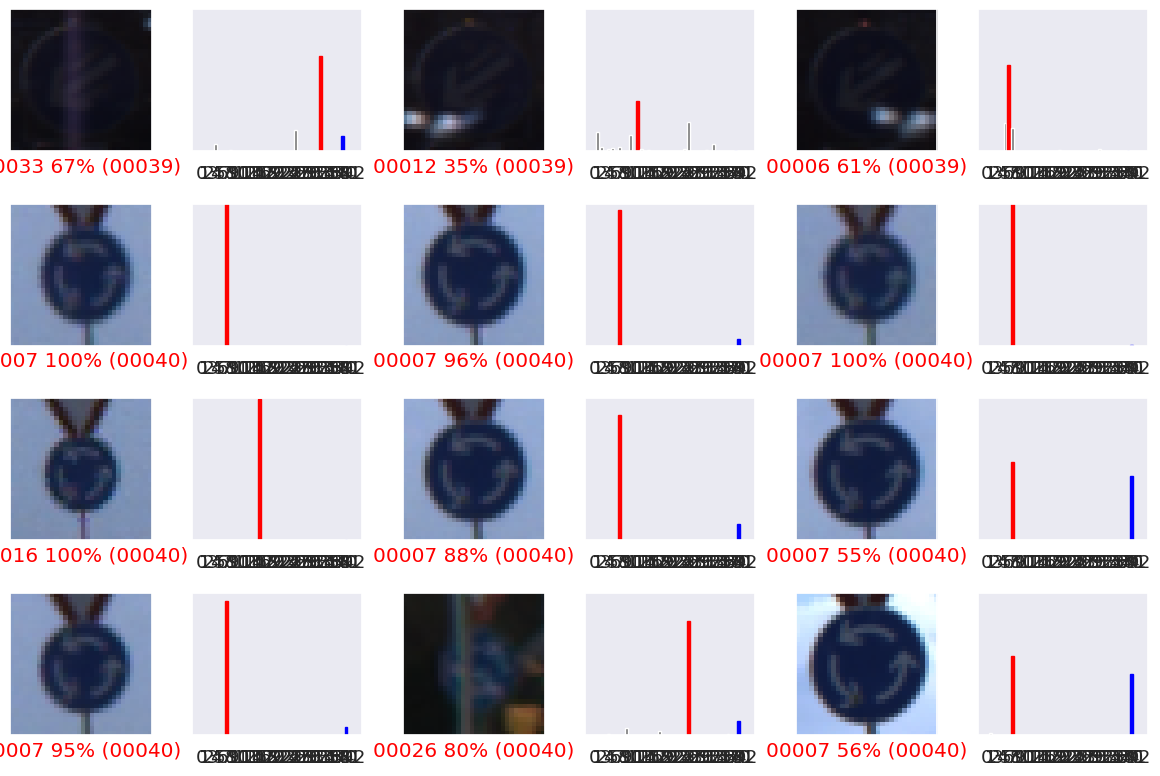

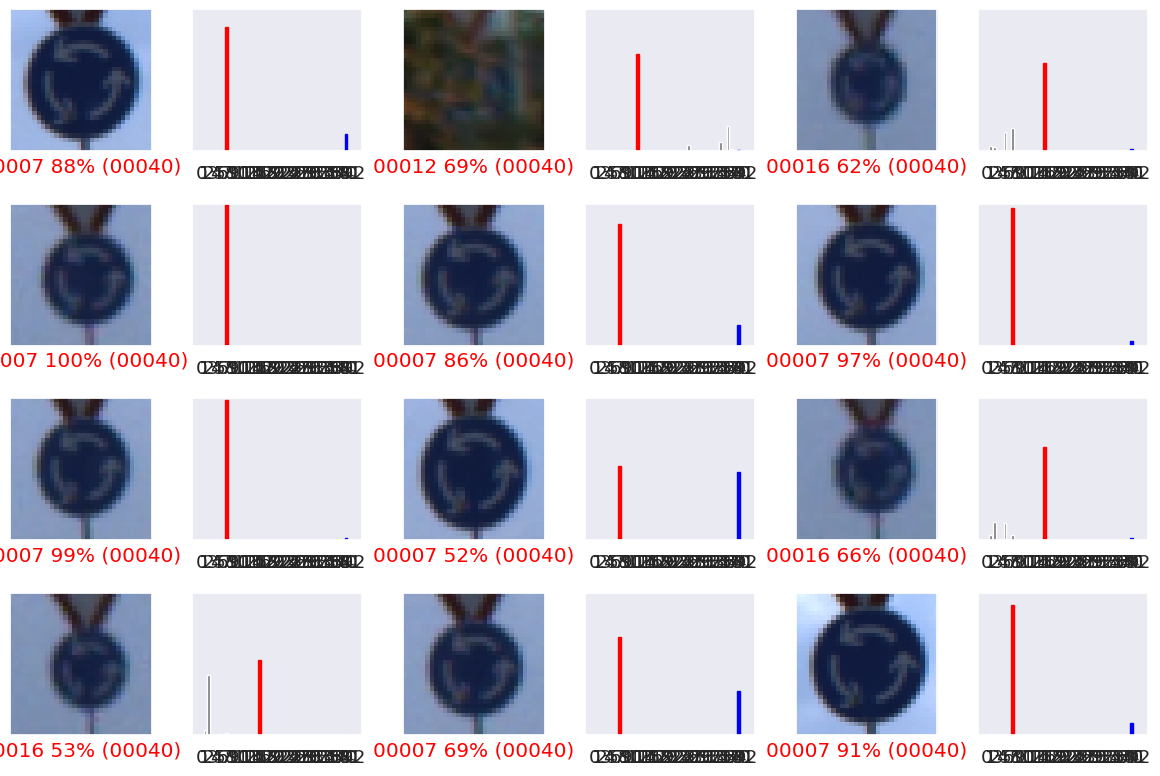

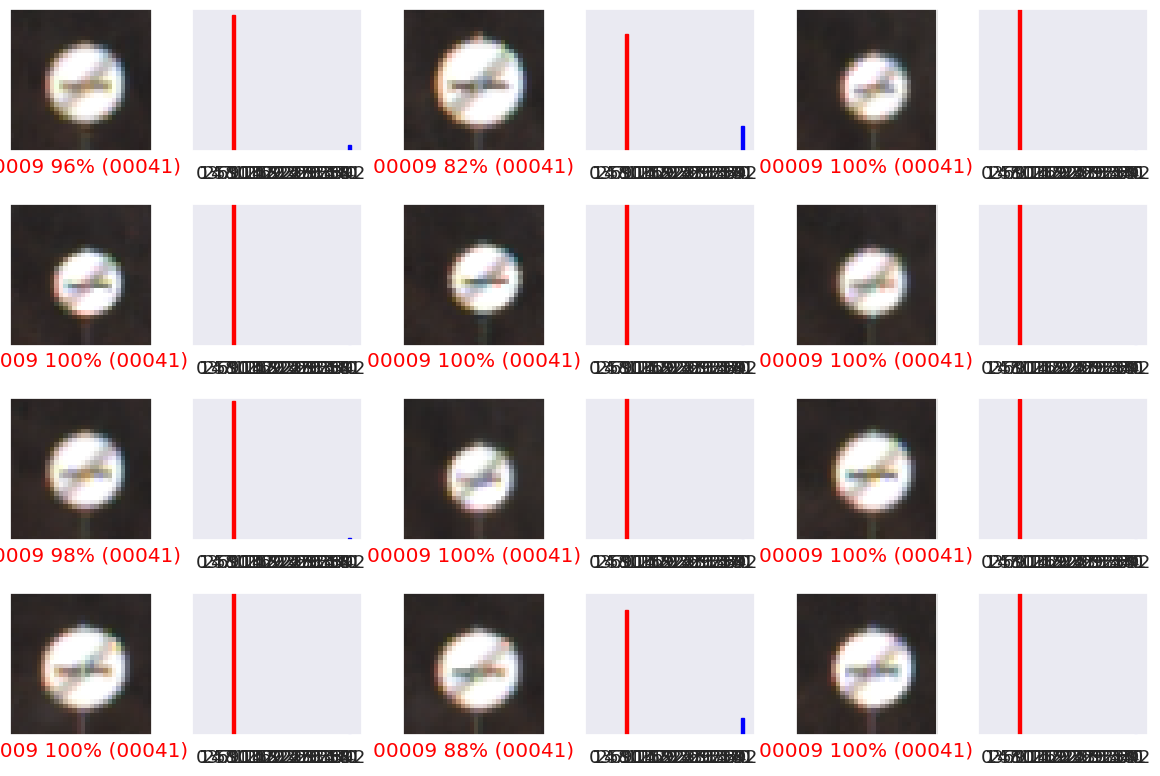

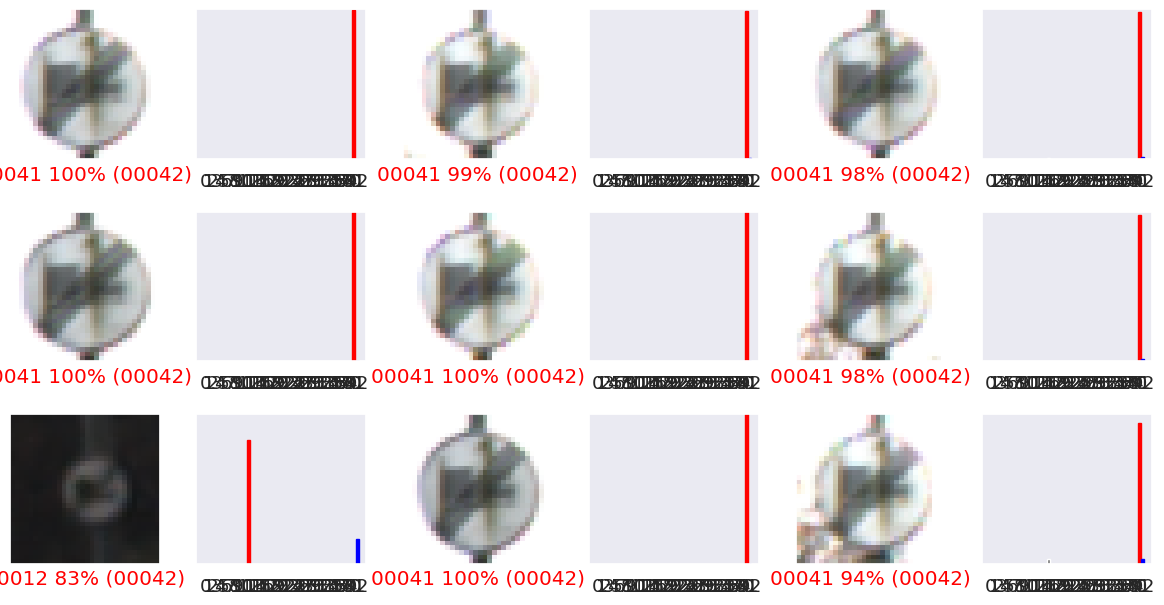

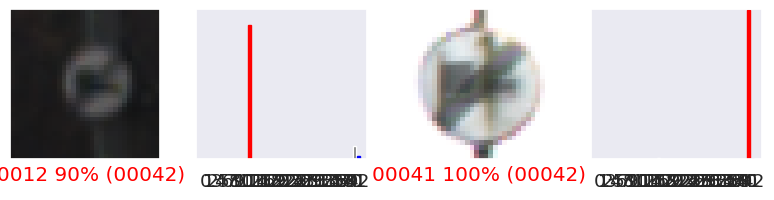

In [17]:
# Iterate over the entire dataset
for images, targets in test_loader:
    logits = model_I(images.to(device))
    predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()

    plot_mismatched(images, predictions, targets.numpy(), train_dataset.classes, 4, 3)



# Analysis

- A lot of the speeds are being misclassified
- Some signals are rotated or obstructed in some way
- A lot of the images also have really low contrast, possibly making it harder to distinguish edges

# Model 2 - Training with Validation set

In [18]:
train_percentage = 0.8
total_samples = len(train_dataset)

train_size = int(train_percentage * total_samples)
val_size = total_samples - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

Training set size: 31367
Validation set size: 7842


In [19]:
def train_and_eval(model, train_loader, val_loader, epochs, loss_fn, optimizer):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time()
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):

            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)

            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        with torch.no_grad():
            v_correct = 0
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)

                v_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')

    return(history)

In [20]:
model_II = CNN()
model_II.to(device)

optimizer_II = torch.optim.Adam(model_II.parameters())

history_II = train_and_eval(model_II, train_loader, val_loader, EPOCHS, criterion, optimizer_II)

Epoch: 000; Loss: 0.0155; Accuracy: 71.7059; Val Acc: 97.5006; Elapsed time: 14.6174
Epoch: 001; Loss: 0.0027; Accuracy: 94.6887; Val Acc: 98.3295; Elapsed time: 14.5767
Epoch: 002; Loss: 0.0018; Accuracy: 96.5888; Val Acc: 99.2221; Elapsed time: 14.7284
Epoch: 003; Loss: 0.0014; Accuracy: 97.3380; Val Acc: 98.7886; Elapsed time: 14.6241
Epoch: 004; Loss: 0.0011; Accuracy: 97.8640; Val Acc: 99.1711; Elapsed time: 14.8074
Epoch: 005; Loss: 0.0011; Accuracy: 97.8991; Val Acc: 99.3242; Elapsed time: 14.6201
Epoch: 006; Loss: 0.0008; Accuracy: 98.3964; Val Acc: 99.3114; Elapsed time: 14.9442
Epoch: 007; Loss: 0.0008; Accuracy: 98.4474; Val Acc: 99.5027; Elapsed time: 14.6810
Epoch: 008; Loss: 0.0007; Accuracy: 98.6451; Val Acc: 99.3114; Elapsed time: 14.9911
Epoch: 009; Loss: 0.0007; Accuracy: 98.7088; Val Acc: 99.4644; Elapsed time: 14.7504
Finished Training


In [21]:
torch.save({
        'model':model_II.state_dict(),
        'optimizer': optimizer_II.state_dict()
        },
        os.path.join(MODEL_PATH, 'model_II.pt'))

In [22]:
evaluate(model_II, test_loader)

0.9717339873313904

# Data Augmentation Part One

- Randomly Rotate images by a max of 5 degrees to add some tilt
- Translate images in both directions up to 10%
- Randomly adjust saturation, brightness, contrast and hue by different percentages (simulating different camera sensors)


In [23]:
# Define the transformations for data augmentation during training
train_augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),  # Randomly rotate images by up to 5 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate images by up to 10% in both directions
    transforms.ColorJitter(hue=0.2, saturation=0.1, brightness=0.1, contrast=0.1),  # Randomly adjust hue, saturation, brightness, and contrast
    transforms.Resize([32, 32]),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to torch Tensors and rescale pixels to [0, 1]
])

# Define the transformations for resizing and converting to tensor during testing
test_resize_transform = transforms.Compose([
    transforms.Resize([32, 32]),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to torch Tensors and rescale pixels to [0, 1]
])


# Import datasets from the directory and apply transformations
train_dataset = datasets.ImageFolder(root='datasets/train_images', transform=train_augmentation_transform)
test_dataset = datasets.ImageFolder(root='datasets/test_images', transform=test_resize_transform)

# Split train_dataset into train_set and val_set
train_percentage = 0.8
total_samples = len(train_dataset)
train_size = int(train_percentage * total_samples)
val_size = total_samples - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Define DataLoaders for training, validation, and testing
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Image shape: torch.Size([64, 3, 32, 32]), label shape: torch.Size([64])
Min and max pixel values: [0.0, 1.0]
Number of classes 40


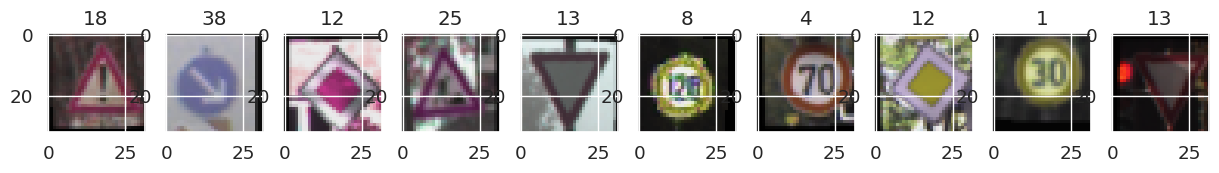

In [24]:
# Visualize some of the new images
for x, y in train_loader:

    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')

    figure, axis = plt.subplots(1, 10, figsize=(15,15))

    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

# Model 3 - Basic Data Augmentation

In [25]:
model_III = CNN()
model_III.to(device)

optimizer_III = torch.optim.Adam(model_III.parameters())

history_III = train_and_eval(model_III, train_loader, val_loader, EPOCHS, criterion, optimizer_III)

Epoch: 000; Loss: 0.0321; Accuracy: 40.8901; Val Acc: 77.5950; Elapsed time: 53.5400
Epoch: 001; Loss: 0.0112; Accuracy: 77.0141; Val Acc: 91.9408; Elapsed time: 52.4087
Epoch: 002; Loss: 0.0068; Accuracy: 86.2818; Val Acc: 95.8812; Elapsed time: 52.7722
Epoch: 003; Loss: 0.0050; Accuracy: 90.1042; Val Acc: 96.9396; Elapsed time: 52.7555
Epoch: 004; Loss: 0.0038; Accuracy: 92.4028; Val Acc: 98.0235; Elapsed time: 52.6964
Epoch: 005; Loss: 0.0030; Accuracy: 94.1276; Val Acc: 98.2657; Elapsed time: 52.9226
Epoch: 006; Loss: 0.0025; Accuracy: 95.1318; Val Acc: 98.6483; Elapsed time: 53.0415
Epoch: 007; Loss: 0.0022; Accuracy: 95.8268; Val Acc: 98.7248; Elapsed time: 52.6573
Epoch: 008; Loss: 0.0020; Accuracy: 96.3242; Val Acc: 99.0054; Elapsed time: 52.8002
Epoch: 009; Loss: 0.0019; Accuracy: 96.3529; Val Acc: 99.1456; Elapsed time: 52.4762
Finished Training


In [26]:
torch.save({
        'model':model_III.state_dict(),
        'optimizer': optimizer_III.state_dict()
        },
        os.path.join(MODEL_PATH, 'model_III.pt'))

In [27]:
evaluate(model_III, test_loader)

0.9800475239753723

In [28]:
# Define the transformations for data augmentation during training
train_augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),  # Randomly rotate images by up to 5 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate images by up to 10% in both directions
    transforms.ColorJitter(hue=0.05, saturation=0.2, brightness=0.2, contrast=0.2),  # Randomly adjust hue, saturation, brightness, and contrast
    transforms.Resize([32, 32]),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to torch Tensors and rescale pixels to [0, 1]
])

# Define the transformations for resizing and converting to tensor during testing
test_resize_transform = transforms.Compose([
    transforms.Resize([32, 32]),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to torch Tensors and rescale pixels to [0, 1]
])


# Import datasets from the directory and apply transformations
train_dataset = datasets.ImageFolder(root='datasets/train_images', transform=train_augmentation_transform)
test_dataset = datasets.ImageFolder(root='datasets/test_images', transform=test_resize_transform)

# Split train_dataset into train_set and val_set
train_percentage = 0.8
total_samples = len(train_dataset)
train_size = int(train_percentage * total_samples)
val_size = total_samples - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Define DataLoaders for training, validation, and testing
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [29]:
model_IV = CNN()
model_IV.to(device)

optimizer_IV = torch.optim.Adam(model_IV.parameters())

history_IV = train_and_eval(model_IV, train_loader, val_loader, EPOCHS, criterion, optimizer_IV)

Epoch: 000; Loss: 0.0298; Accuracy: 44.1292; Val Acc: 76.4473; Elapsed time: 52.6508
Epoch: 001; Loss: 0.0102; Accuracy: 78.7229; Val Acc: 92.8080; Elapsed time: 52.2409
Epoch: 002; Loss: 0.0061; Accuracy: 87.6909; Val Acc: 95.0650; Elapsed time: 52.4809
Epoch: 003; Loss: 0.0044; Accuracy: 91.1436; Val Acc: 97.2711; Elapsed time: 52.7930
Epoch: 004; Loss: 0.0033; Accuracy: 93.3401; Val Acc: 97.6792; Elapsed time: 52.8245
Epoch: 005; Loss: 0.0027; Accuracy: 94.5484; Val Acc: 98.0235; Elapsed time: 52.6376
Epoch: 006; Loss: 0.0023; Accuracy: 95.6387; Val Acc: 98.2657; Elapsed time: 52.6074
Epoch: 007; Loss: 0.0019; Accuracy: 96.3050; Val Acc: 98.7758; Elapsed time: 52.2976
Epoch: 008; Loss: 0.0017; Accuracy: 96.7195; Val Acc: 98.8651; Elapsed time: 52.7398
Epoch: 009; Loss: 0.0016; Accuracy: 96.9841; Val Acc: 99.0691; Elapsed time: 52.4056
Finished Training


In [30]:
evaluate(model_IV, test_loader)

0.9798891544342041

# Model 5 - More Data Augmentation


In [31]:
from PIL import Image  # Import the Image class


# Define custom transforms
class RandomShear(object):
    def __call__(self, sample):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample
        angle = random.uniform(-0.475, 0.475)
        tx = random.uniform(-0.4, 0.4)
        image = TF.affine(image, angle=angle, translate=(tx, 0), scale=1, shear=0)
        if isinstance(sample, tuple):
            return image, label
        else:
            return image

class RandomSaltAndPepper(object):
    def __init__(self, prob_salt=0.005, prob_pepper=0.005):
        self.prob_salt = prob_salt
        self.prob_pepper = prob_pepper

    def __call__(self, sample):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample

        if isinstance(image, torch.Tensor):
            random_values = torch.rand(image.shape[-2:])
            image[random_values < self.prob_salt] = 1.0
            image[1 - random_values < self.prob_pepper] = 0.0
        else:
            width, height = image.size
            pixels = image.load()
            for x in range(width):
                for y in range(height):
                    if random.random() < self.prob_salt:
                        pixels[x, y] = (255, 255, 255)
                    elif random.random() < self.prob_pepper:
                        pixels[x, y] = (0, 0, 0)

        if isinstance(sample, tuple):
            return image, label
        else:
            return image

class RandomCutout(object):
    def __call__(self, sample):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample

        width, height = image.size
        size_hor = random.randint(0, 16) // 2 * 2
        size_ver = random.randint(0, 16) // 2 * 2
        i = random.randint(0, height - size_ver)
        j = random.randint(0, width - size_hor)
        mask = TF.to_tensor(image).clone().zero_()
        mask[:, i:i + size_ver, j:j + size_hor] = 1
        image = TF.to_pil_image(TF.to_tensor(image) * mask)

        if isinstance(sample, tuple):
            return image, label
        else:
            return image



class RandomBlock(object):
    def __call__(self, sample):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample

        width, height = image.size
        block_width = random.randint(0, 8)  # Adjust the size of the block as needed
        block_height = random.randint(0, 8)
        block_color = (0, 0, 0)  # Color of the block (black in this example)
        x = random.randint(0, width - block_width)
        y = random.randint(0, height - block_height)

        # Create a new image with the block drawn on it
        block_image = Image.new('RGB', (block_width, block_height), block_color)
        image.paste(block_image, (x, y))

        if isinstance(sample, tuple):
            return image, label
        else:
            return image

# Usage
train_augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),  # Randomly rotate images by up to 5 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate images by up to 10% in both directions
    transforms.ColorJitter(hue=0.2, saturation=0.1, brightness=0.1, contrast=0.1),  # Randomly adjust hue, saturation, brightness, and contrast
    RandomShear(),
    RandomSaltAndPepper(),
    # RandomCutout(),
    RandomBlock(),
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
])


# Define the transformations for resizing and converting to tensor during testing
test_resize_transform = transforms.Compose([
    transforms.Resize([32, 32]),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to torch Tensors and rescale pixels to [0, 1]
])


# Import datasets from the directory and apply transformations
train_dataset = datasets.ImageFolder(root='datasets/train_images', transform=train_augmentation_transform)
test_dataset = datasets.ImageFolder(root='datasets/test_images', transform=test_resize_transform)

# Split train_dataset into train_set and val_set
train_percentage = 0.8
total_samples = len(train_dataset)
train_size = int(train_percentage * total_samples)
val_size = total_samples - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Define DataLoaders for training, validation, and testing
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Image shape: torch.Size([64, 3, 32, 32]), label shape: torch.Size([64])
Min and max pixel values: [0.0, 1.0]
Number of classes 41


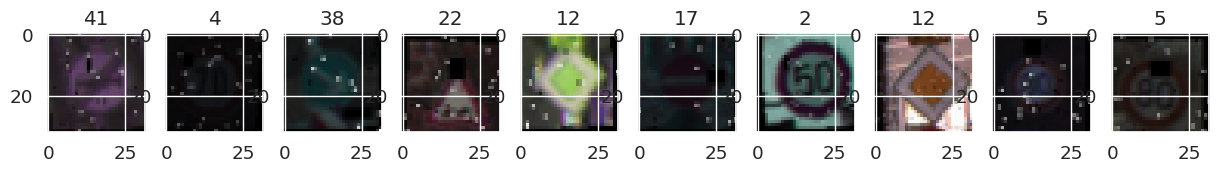

In [32]:
# Visualize some of the new images
for x, y in train_loader:

    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')

    figure, axis = plt.subplots(1, 10, figsize=(15,15))

    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

In [33]:
model_V = CNN()
model_V.to(device)

optimizer_V = torch.optim.Adam(model_V.parameters())

history_V = train_and_eval(model_V, train_loader, val_loader, EPOCHS, criterion, optimizer_V)

Epoch: 000; Loss: 0.0367; Accuracy: 32.6904; Val Acc: 59.4491; Elapsed time: 85.3343
Epoch: 001; Loss: 0.0184; Accuracy: 62.3235; Val Acc: 80.0944; Elapsed time: 84.6081
Epoch: 002; Loss: 0.0132; Accuracy: 73.1979; Val Acc: 84.2642; Elapsed time: 85.0701
Epoch: 003; Loss: 0.0100; Accuracy: 79.7207; Val Acc: 89.1099; Elapsed time: 85.0274
Epoch: 004; Loss: 0.0084; Accuracy: 83.1001; Val Acc: 90.5509; Elapsed time: 85.1727
Epoch: 005; Loss: 0.0068; Accuracy: 86.6420; Val Acc: 93.0885; Elapsed time: 84.8945
Epoch: 006; Loss: 0.0059; Accuracy: 88.3444; Val Acc: 93.1395; Elapsed time: 85.4913
Epoch: 007; Loss: 0.0051; Accuracy: 90.0182; Val Acc: 94.7207; Elapsed time: 85.1467
Epoch: 008; Loss: 0.0045; Accuracy: 91.1946; Val Acc: 95.4476; Elapsed time: 86.2164
Epoch: 009; Loss: 0.0040; Accuracy: 92.3837; Val Acc: 95.3966; Elapsed time: 85.9162
Finished Training


In [35]:
evaluate(model_V, test_loader)

0.8642913699150085

In [38]:
from PIL import Image  # Import the Image class


# Define custom transforms
class RandomShear(object):
    def __call__(self, sample):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample
        angle = random.uniform(-0.475, 0.475)
        tx = random.uniform(-0.4, 0.4)
        image = TF.affine(image, angle=angle, translate=(tx, 0), scale=1, shear=0)
        if isinstance(sample, tuple):
            return image, label
        else:
            return image

class RandomSaltAndPepper(object):
    def __init__(self, prob_salt=0.005, prob_pepper=0.005):
        self.prob_salt = prob_salt
        self.prob_pepper = prob_pepper

    def __call__(self, sample):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample

        if isinstance(image, torch.Tensor):
            random_values = torch.rand(image.shape[-2:])
            image[random_values < self.prob_salt] = 1.0
            image[1 - random_values < self.prob_pepper] = 0.0
        else:
            width, height = image.size
            pixels = image.load()
            for x in range(width):
                for y in range(height):
                    if random.random() < self.prob_salt:
                        pixels[x, y] = (255, 255, 255)
                    elif random.random() < self.prob_pepper:
                        pixels[x, y] = (0, 0, 0)

        if isinstance(sample, tuple):
            return image, label
        else:
            return image

class RandomCutout(object):
    def __call__(self, sample):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample

        width, height = image.size
        size_hor = random.randint(0, 16) // 2 * 2
        size_ver = random.randint(0, 16) // 2 * 2
        i = random.randint(0, height - size_ver)
        j = random.randint(0, width - size_hor)
        mask = TF.to_tensor(image).clone().zero_()
        mask[:, i:i + size_ver, j:j + size_hor] = 1
        image = TF.to_pil_image(TF.to_tensor(image) * mask)

        if isinstance(sample, tuple):
            return image, label
        else:
            return image



class RandomBlock(object):
    def __call__(self, sample):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample

        width, height = image.size
        block_width = random.randint(0, 8)  # Adjust the size of the block as needed
        block_height = random.randint(0, 8)
        block_color = (0, 0, 0)  # Color of the block (black in this example)
        x = random.randint(0, width - block_width)
        y = random.randint(0, height - block_height)

        # Create a new image with the block drawn on it
        block_image = Image.new('RGB', (block_width, block_height), block_color)
        image.paste(block_image, (x, y))

        if isinstance(sample, tuple):
            return image, label
        else:
            return image

# Usage
train_augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),  # Randomly rotate images by up to 5 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate images by up to 10% in both directions
    transforms.ColorJitter(hue=0.05, saturation=0.1, brightness=0.1, contrast=0.1),  # We no longer adjust hue
    RandomSaltAndPepper(),
    # RandomCutout(),
    RandomBlock(),
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
])


# Define the transformations for resizing and converting to tensor during testing
test_resize_transform = transforms.Compose([
    transforms.Resize([32, 32]),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to torch Tensors and rescale pixels to [0, 1]
])


# Import datasets from the directory and apply transformations
train_dataset = datasets.ImageFolder(root='datasets/train_images', transform=train_augmentation_transform)
test_dataset = datasets.ImageFolder(root='datasets/test_images', transform=test_resize_transform)

# Split train_dataset into train_set and val_set
train_percentage = 0.8
total_samples = len(train_dataset)
train_size = int(train_percentage * total_samples)
val_size = total_samples - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Define DataLoaders for training, validation, and testing
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Image shape: torch.Size([64, 3, 32, 32]), label shape: torch.Size([64])
Min and max pixel values: [0.0, 1.0]
Number of classes 41


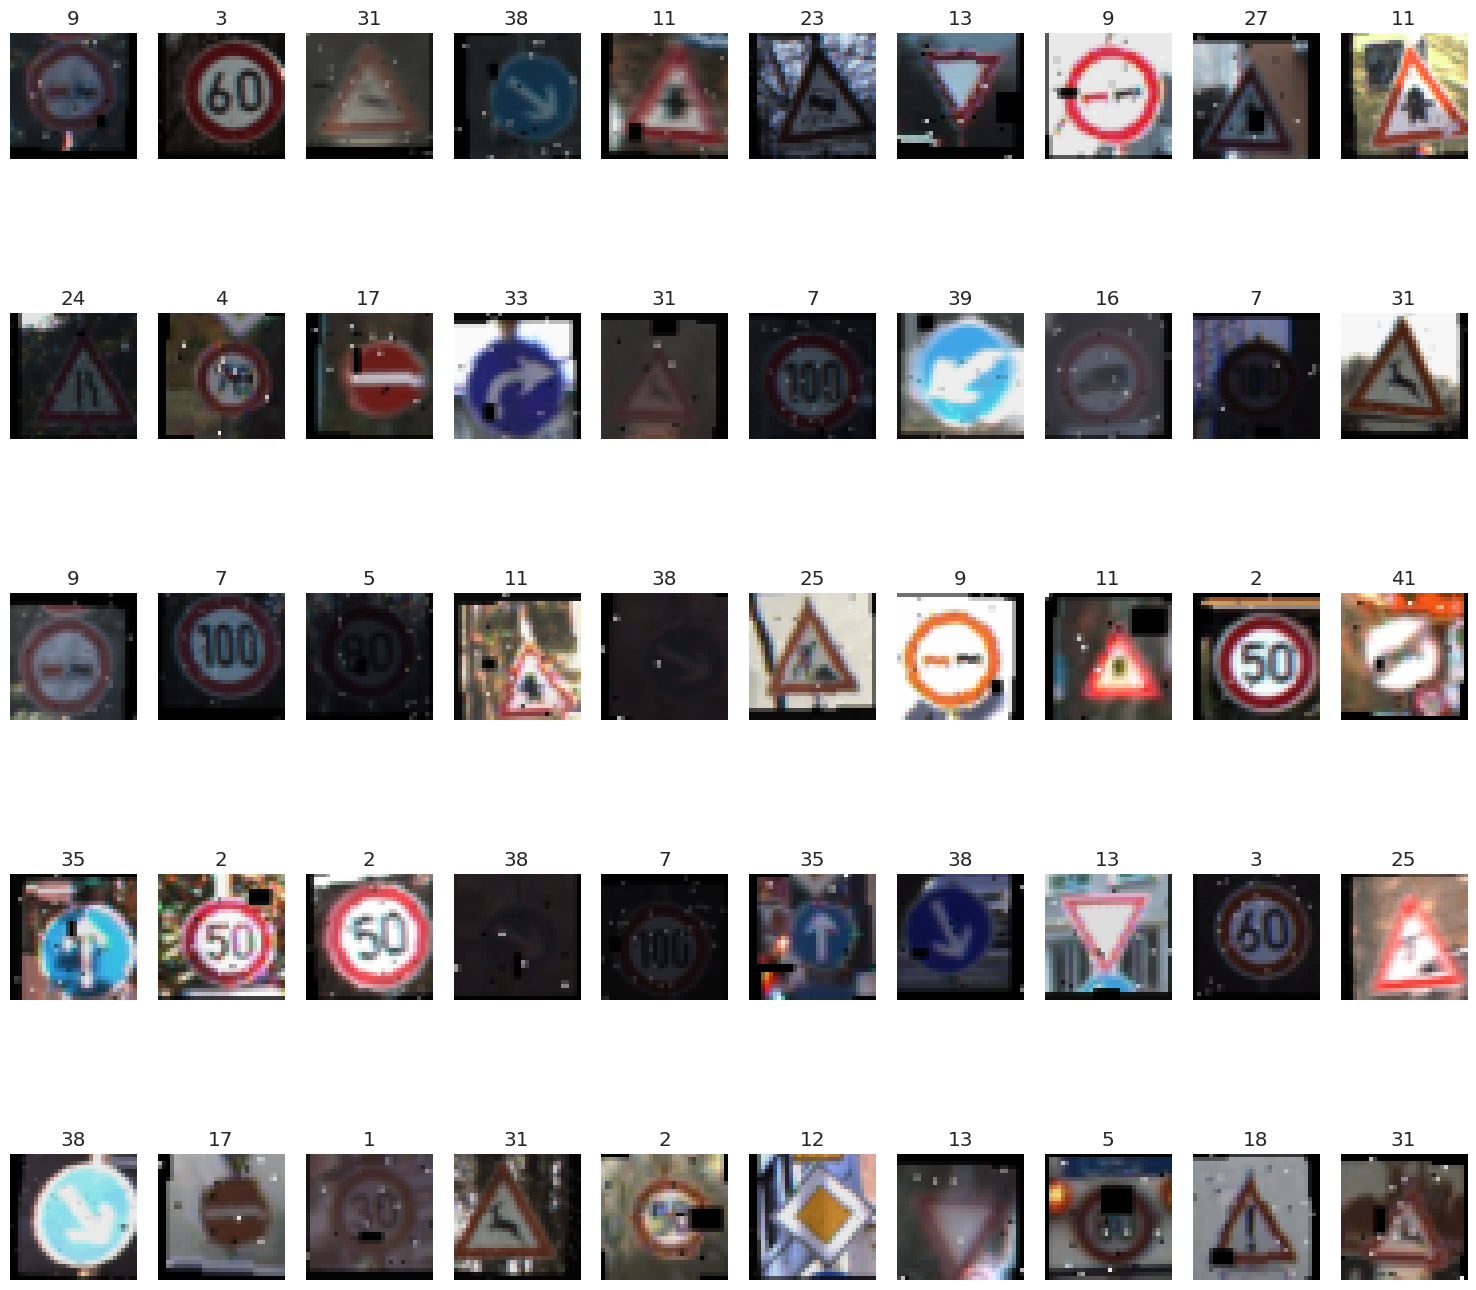

In [40]:
# Assuming train_loader is defined and provides batches of images and labels
for x, y in train_loader:
    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')

    # Create a figure with 5 rows and 10 columns of subplots
    figure, axes = plt.subplots(5, 10, figsize=(15, 15))

    for idx in range(50):  # We want to display 50 images in total
        row = idx // 10
        col = idx % 10
        axes[row, col].imshow(x[idx].permute(1, 2, 0))
        axes[row, col].set_title(y[idx].item())
        axes[row, col].axis('off')  # Hide the axes

    plt.tight_layout()
    plt.show()
    break

In [41]:
model_VI = CNN()
model_VI.to(device)

optimizer_VI = torch.optim.Adam(model_VI.parameters())

history_VI = train_and_eval(model_VI, train_loader, val_loader, EPOCHS, criterion, optimizer_VI)

Epoch: 000; Loss: 0.0330; Accuracy: 38.1834; Val Acc: 70.5050; Elapsed time: 81.7723
Epoch: 001; Loss: 0.0146; Accuracy: 69.9589; Val Acc: 83.7796; Elapsed time: 81.3864
Epoch: 002; Loss: 0.0100; Accuracy: 79.6570; Val Acc: 88.9824; Elapsed time: 81.3562
Epoch: 003; Loss: 0.0075; Accuracy: 84.9651; Val Acc: 92.6549; Elapsed time: 81.3649
Epoch: 004; Loss: 0.0059; Accuracy: 87.9300; Val Acc: 94.4147; Elapsed time: 81.3534
Epoch: 005; Loss: 0.0049; Accuracy: 90.1776; Val Acc: 95.7026; Elapsed time: 81.5123
Epoch: 006; Loss: 0.0042; Accuracy: 91.7078; Val Acc: 94.8865; Elapsed time: 81.5737
Epoch: 007; Loss: 0.0038; Accuracy: 92.5527; Val Acc: 96.7228; Elapsed time: 81.5796
Epoch: 008; Loss: 0.0035; Accuracy: 93.1648; Val Acc: 96.9778; Elapsed time: 81.6504
Epoch: 009; Loss: 0.0029; Accuracy: 94.3858; Val Acc: 97.5261; Elapsed time: 81.8997
Finished Training


In [42]:
history_VII = train_and_eval(model_VI, train_loader, val_loader, EPOCHS, criterion, optimizer_VI)

Epoch: 000; Loss: 0.0027; Accuracy: 94.8417; Val Acc: 97.3986; Elapsed time: 81.8703
Epoch: 001; Loss: 0.0025; Accuracy: 95.3327; Val Acc: 98.2020; Elapsed time: 81.5458
Epoch: 002; Loss: 0.0021; Accuracy: 95.8268; Val Acc: 98.1637; Elapsed time: 81.9720
Epoch: 003; Loss: 0.0022; Accuracy: 95.8364; Val Acc: 98.0107; Elapsed time: 81.7723
Epoch: 004; Loss: 0.0020; Accuracy: 96.2859; Val Acc: 98.5590; Elapsed time: 82.1358
Epoch: 005; Loss: 0.0017; Accuracy: 96.5824; Val Acc: 98.4953; Elapsed time: 81.5808
Epoch: 006; Loss: 0.0018; Accuracy: 96.5505; Val Acc: 98.7376; Elapsed time: 82.0283
Epoch: 007; Loss: 0.0017; Accuracy: 96.7673; Val Acc: 98.7248; Elapsed time: 81.6815
Epoch: 008; Loss: 0.0017; Accuracy: 96.8725; Val Acc: 98.2657; Elapsed time: 81.9830
Epoch: 009; Loss: 0.0014; Accuracy: 97.2901; Val Acc: 98.6993; Elapsed time: 82.2911
Finished Training


In [43]:
evaluate(model_VI, test_loader)

0.9859066009521484